In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import random
import math
import torch
import copy
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import gc
import mads_dl

from PIL import Image
from IPython.display import Image
import matplotlib.cm as cm
import seaborn as sns
torch.manual_seed(1)
from classes import *
# set all columns to be displayed
pd.set_option('display.max_columns', None)

loaddata = LoadData()


2024-11-20 14:27:44.325013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732109264.338802    6182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732109264.342805    6182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 14:27:44.356664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classes

## Loading Data Classes

In [2]:
# 'FA_20231206_2H_yeast_Pyruvate-d3_1.ser.csv'
# 'FA_20240517_2H_yeast_Nicotinamide-d4 _9.csv'
# 'FA_20240213_2H_yeast_Fumarate-d2_9.csv
file = str(Path('FA_20231123_2H Yeast_Fumarate-d2_12 .csv'))
substrates = loaddata.get_substrate_list(file)
metabolites = loaddata.get_metabolite_list(file)
substrates = [float(i) for i in substrates]
metabolites = [float(i) for i in metabolites]
path_list = loaddata.load_data(file)

In [3]:
print(substrates, metabolites)

[6.653, 4.7] [4.368, 2.474]


# Step 1: Loading the data

In [4]:
# shapes of all the csv files
path_list2 = loaddata.load_data('.csv')

for path in path_list2:
    df = pd.read_csv(path)
    print(df.shape)

(632, 51)
(622, 236)
(806, 151)
(1063, 51)
(837, 238)
(654, 51)
(585, 236)
(960, 131)
(855, 131)
(577, 236)
(679, 151)
(1429, 131)
(1583, 131)
(1170, 236)
(966, 51)
(1527, 131)
(841, 41)
(2003, 131)
(843, 238)
(859, 236)
(706, 131)
(1226, 131)
(880, 131)
(779, 131)
(695, 131)
(778, 51)
(636, 237)
(653, 131)
(1045, 131)
(925, 71)
(793, 236)
(718, 238)
(782, 236)
(2122, 131)
(1279, 131)
(1632, 131)
(941, 238)
(537, 236)
(1796, 101)
(890, 237)
(823, 131)
(1503, 131)
(861, 151)
(681, 236)
(1147, 51)
(755, 131)
(608, 238)
(1480, 237)
(2268, 131)
(1045, 181)
(1023, 51)
(1418, 238)
(691, 236)
(735, 131)
(655, 236)
(1139, 181)
(921, 131)
(1675, 131)
(673, 236)
(645, 238)
(1074, 131)
(908, 51)
(957, 131)
(877, 40)
(1297, 131)
(951, 131)
(1594, 131)
(799, 131)
(776, 236)
(971, 237)
(1675, 131)
(1178, 237)
(2072, 131)
(898, 51)


In [5]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(2268, 131)


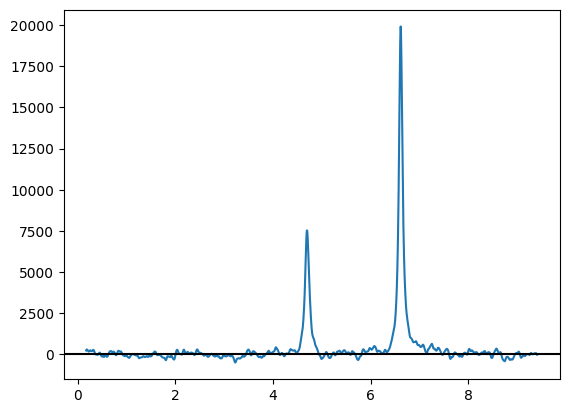

In [6]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)

# show x  lines
plt.axhline(y=0, color='k')
plt.show()

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

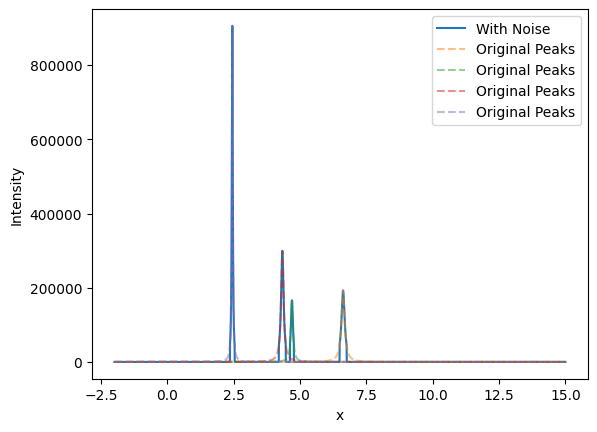

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma / ((x - x0)**2 + gamma**2))

def gaussian_curve(x, mu=0, sigma=1, height=1):
    """
    Gaussian function with specified height at the peak.
    
    Parameters:
    - x: numpy array or scalar, the input values.
    - mu: float, the mean/center of the curve (default 0).
    - sigma: float, the standard deviation of the Gaussian curve (default 1).
    - height: float, the desired height of the peak of the Gaussian curve.
    
    Returns:
    - numpy array or scalar representing the Gaussian curve.
    """
    return height * np.exp(-0.5 * ((x - mu) / sigma)**2)

def pseudo_voigt(x, mu=0, sigma=1, gamma=1, eta=0.5, height=1):
    """
    Pseudo-Voigt function: a linear combination of Gaussian and Lorentzian curves.

    Parameters:
    - x: numpy array or scalar, the input values.
    - mu: float, the mean/center of the curve.
    - sigma: float, the standard deviation of the Gaussian component.
    - gamma: float, the half-width at half-maximum (HWHM) of the Lorentzian component.
    - eta: float, the mixing parameter (0 = pure Gaussian, 1 = pure Lorentzian).

    Returns:
    - numpy array or scalar representing the pseudo-Voigt profile.
    """
    if not (0 <= eta <= 1):
        raise ValueError("Eta must be between 0 and 1.")
    
    gaussian = gaussian_curve(x, mu, sigma, height=height)
    lorentzian_val = lorentzian(x, mu, gamma, height=height)
    return eta * lorentzian_val + (1 - eta) * gaussian




def generate_random_spectrum(peak_list, spectrum_length=3000):

    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 15, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    x0_parms = []
    gamma_parms = []
    height_parms = []

    x0_substrate_parms = []
    gamma_substrate_parms = []
    height_substrate_parms = []

    # let peakist ranomd jump left and right

    peak_list = np.array(peak_list) + np.random.uniform(-0.1, 0.1)

    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.02, 0.02)
        
        metabolism_gamma = np.random.uniform(0.009, 0.08)  # Random width (gamma)
        metabolism_height = np.random.uniform(100, 20000)  # Random height
        # select random function:
        #peak_lorenz = gaussian_curve(x=x, mu=metabolism_x0, sigma=metabolism_gamma, height=metabolism_height)
        peak_lorenz = lorentzian(x=x, gamma=metabolism_gamma, height=metabolism_height, x0=metabolism_x0)
        #peak_lorenz = pseudo_voigt(x=x, mu=metabolism_x0, sigma=metabolism_gamma, gamma=metabolism_gamma, eta=np.random.uniform(0, 1), height=metabolism_height)

        #peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y = np.maximum(y, peak_lorenz)  # Use maximum to avoid summing peaks

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * metabolism_height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)



    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(0, df.max().max())
    gaussian_noise = np.random.normal(0, 500, 3000)
    laplace_noise = np.random.laplace(0, 500, 3000)

    # choose random between noise1 and noise2
    noise = gaussian_noise if np.random.rand() > 0.5 else laplace_noise

    #noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level /1
    #noise = gaussian_filter1d(noise, sigma=sigma)
    # rollwing window mean
    noise = np.convolve(noise, np.ones(50)/50, mode='same')
    
    
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    # set everything below treshold to zero
    
    # Calculate the 80 percentile 
    percentile = np.percentile(y_noisy, 95)

    y_clean = np.where(y_noisy < percentile, 0, y_noisy)

    #print(y_noisy.shape, y_clean.shape)

    

    return x, y_clean, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

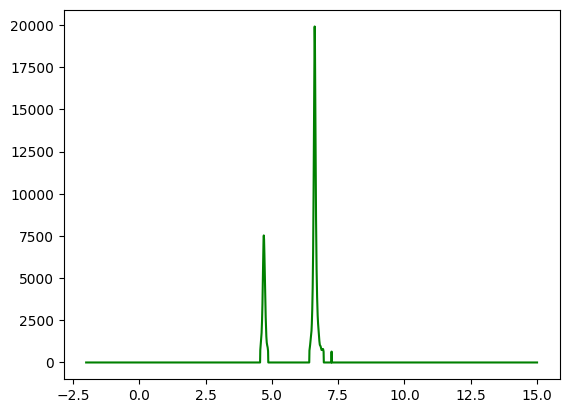

(4177, 2)


,x,y
0,-2.000000,0.0
1,-1.995927,0.0
2,-1.991855,0.0
3,-1.987782,0.0
4,-1.983710,0.0
...,...,...
4172,14.983135,0.0
4173,14.987208,0.0
4174,14.991280,0.0
4175,14.995353,0.0


In [8]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=3000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    treshold = 95

    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 0
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = (y_sample.min()), abs(y_sample.max())
    #print(y_min, y_max)

    # get the min max of the x values
    x_min, x_max = x.min(), x.min()

    if x_min > -2:


        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))


        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        #percentile = np.percentile(y_new, treshold)

        #y_new = np.where(y_new < percentile, 0, y_new)

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 15:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 15, step)
        #print(x_new)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        #percentile = np.percentile(y_new, treshold)

        #y_new = np.where(y_new < percentile, 0, y_new)

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)

    percentile = df['y'].quantile(treshold/100)

    df.loc[df['y'] < percentile, 'y'] = 0

    #display(df)
                
    return df


df_fill = df.iloc[:, [0,1]]
#print(df_fill.head())
df_filled = fill_df(df_fill)
#print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
#plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.show()
print(df_filled.shape)
display(df_filled)

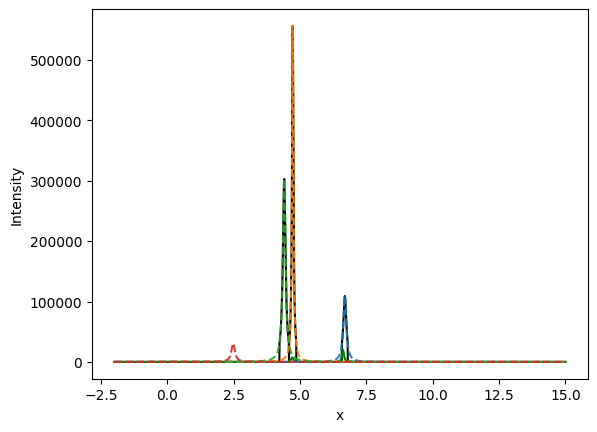

In [9]:
# visualize random spectra and real spectra


substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise", color='black')
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.9)  



#plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('Intensity')
plt.show()

# Step 3: Bring data to same shape

(3000, 2)


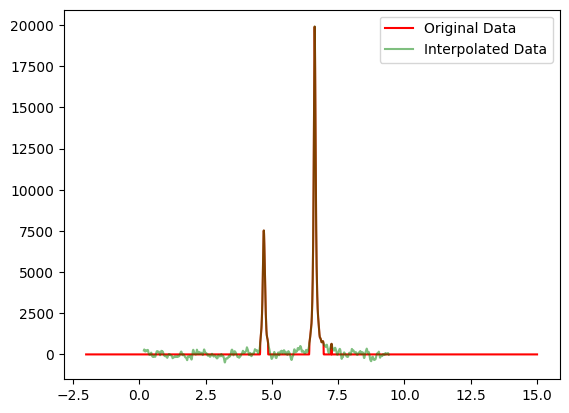

In [10]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=3000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
#plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], color='red',)
plt.plot(df.iloc[:, 0], df.iloc[:, 1], color='green', alpha=0.5)
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [11]:
df_interpolated.shape

(3000, 2)

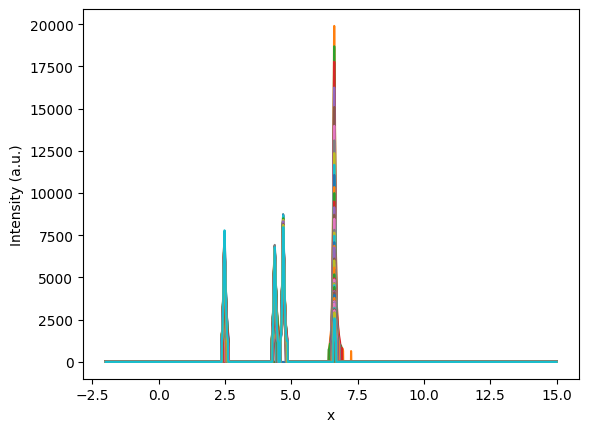

In [12]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=3000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
substrates_list = substrates + metabolites
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)


#plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [13]:

num_samples = 20000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    substrates_list = substrates + metabolites
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

/tmp/ipykernel_6182/2502958047.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_data = torch.tensor(x_data)


x_data shape: torch.Size([20000, 3000])
data shape: torch.Size([20000, 3000])
x_params_tensor shape: torch.Size([20000, 4])
gamma_params_tensor shape: torch.Size([20000, 4])
height_params_tensor shape: torch.Size([20000, 4])
target shape: torch.Size([20000, 12])




In [14]:

def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([20000, 3000])
Before Scaling: torch.Size([20000, 12])
After Reshaping: torch.Size([20000, 3000])
After Reshaping: torch.Size([20000, 12])
After Scaling: (20000, 3000)
After Scaling: (20000, 12)


In [15]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_tmp, target_train, target_tmp = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
data_val, data_test, target_val, target_test = train_test_split(data_tmp, target_tmp,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)

# import StandardScaler
from sklearn.preprocessing import StandardScaler

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train)
data_val_sc = data_scaler.transform(data_val)
data_test_sc = data_scaler.transform(data_test)

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train)
target_val_sc = target_scaler.transform(target_val)
target_test_sc = target_scaler.transform(target_test)


# Konvertieren in Tensoren
data_train_tensor = torch.tensor(data_train_sc, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val_sc, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test_sc, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train_sc, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val_sc, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test_sc, dtype=torch.float32)





# # Reshape the tensors for the model
# target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
# target_val_tensor = target_val_tensor.reshape(target_val_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Val Shape: {data_val_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Val Shape: {target_val_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([12000, 3000])
Data Val Shape: torch.Size([4000, 3000])
Data Test Shape: torch.Size([4000, 3000])
Target Train Shape: torch.Size([12000, 12])
Target Val Shape: torch.Size([4000, 12])
Target Test Shape: torch.Size([4000, 12])


# LSTM 

In [16]:
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()

#         self.reduce = nn.Linear(3000, hidden_size)

#         # Define LSTM with correct hidden size
#         self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)

#         # Fully connected layers with corrected input sizes
#         self.fc1 = nn.Sequential(
#             nn.Linear(hidden_size, 128),  # Match hidden_size with the output of LSTM
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(32, 16),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(16, output_size)

#     def forward(self, x):
#         # Check shape before reducing
#         #print(f"Input shape before reduction: {x.shape}")  # For debugging
#         x = self.reduce(x)  # This should expect (batch_size, 3000)
        

#         # Reshape for LSTM input
#         x = x.reshape(x.shape[0], 1, -1)  # Reshape to (batch_size, seq_len, input_size)
#         #print(f"Shape after reduction: {x.shape}")

#         batch_size = x.shape[0]
        
#         # Initialize hidden and cell states with hidden_size instead of input_size
#         h_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)
#         #c_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)

#         # Pass data through LSTM
#         x, _ = self.lstm(x, (h_0))
#         x = x[:, -1, :]  # Take the output from the last time step

#         # Pass data through fully connected layers
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

#         # Final output
#         output = self.output(x)
#         return output
    
#     def predict(self, X):
#         '''
#         Use the model to predict for the values in the test set.
#         Return the prediction
#         '''
#         model.eval()
#         with torch.no_grad():
#             return model(X)


In [17]:
print(data_train_tensor.shape, target_train_tensor.shape)

torch.Size([12000, 3000]) torch.Size([12000, 12])


# Conv1D

In [18]:
# import torch
# import torch.nn as nn

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()
        
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=2, stride=2, padding=0),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )
#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        

#         # Fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(3000, 1000),  # Adjust for pooling effects
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1000, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(3000, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(32, output_size)

#     def forward(self, x):
#         # Apply convolutional layers with pooling
        
#         x = x.unsqueeze(1)
#         x = self.firstpooling(x)
#         x = self.conv1(x)      
#         x = self.conv2(x)  

#         #print(x.shape)
#         # Flatten the output for fully connected layers
#         x = x.reshape(x.shape[0], -1)        
#         # Pass through fully connected layers
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         x = self.fc3(x)

#         # Output layer
#         output = self.output(x)
#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)


In [19]:
# import torch
# import torch.nn as nn
# import math

# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  input_size=3000, 
#                  hidden_size=128, 
#                  output_size=27, 
#                  dropout_prob=0.2,
#                  avgpool_kernel_size=2,
#                  avgpool_stride=2,
#                  avgpool_padding=0,

#                  conv1_in_channels=1,
#                  conv1_out_channels=8,
#                  conv1_kernel_size=3,
#                  conv1_stride=1,
#                  conv1_padding=1,

#                  conv2_in_channels=8,
#                  conv2_out_channels=12,
#                  conv2_kernel_size=3,
#                  conv2_stride=1,
#                  conv2_padding=1,
#                  fc1_out_features=128,
                
#                  fc3_out_features=32):
#         super(NeuralNetwork, self).__init__()
        
#         # Pooling and activation
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=avgpool_kernel_size, stride=avgpool_stride, padding=avgpool_padding),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )

#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, 
#                       kernel_size=conv1_kernel_size, stride=conv1_stride, padding=conv1_padding),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )

#         # self.conv2 = nn.Sequential(
#         #     nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, 
#         #               kernel_size=conv2_kernel_size, stride=conv2_stride, padding=conv2_padding),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob),
#         #     nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         # )

#         # Compute output size after convolution and pooling
#         def compute_output_size(input_len, kernel_size, stride, padding, layers=1):
#             for _ in range(layers):
#                 input_len = math.floor((input_len + 2 * padding - (kernel_size - 1) - 1) / stride + 1)
#             return input_len

#         pooled_size = compute_output_size(input_size, avgpool_kernel_size, avgpool_stride, avgpool_padding)
#         conv1_size = compute_output_size(pooled_size, conv1_kernel_size, conv1_stride, conv1_padding)
#         conv1_pooled = math.floor(conv1_size / 2)  # Max pooling halves the size
#         conv2_size = compute_output_size(conv1_pooled, conv2_kernel_size, conv2_stride, conv2_padding)
#         conv2_pooled = math.floor(conv2_size / 2)  # Max pooling halves the size again

#         flattened_size = conv1_out_channels * conv1_pooled

#         # # Fully connected layers
#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(flattened_size, fc1_out_features),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob)
#         # )

#         self.fc2 = nn.Sequential(
#             nn.Linear(flattened_size, fc3_out_features),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(fc3_out_features, output_size)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension
#         x = self.firstpooling(x)
#         x = self.conv1(x)
#         #x = self.conv2(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten
#         #x = self.fc1(x)
#         x = self.fc2(x)
#         output = self.output(x)

#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)

# Linear Layer

In [20]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, 
                 input_size=3000, 
                 fc1_output=512,
                 #fc2_output = 512, 
                 output_size=len(substrates_list) * 3, 
                 dropout_prob=0.1,
                 kernel_size=2,
                 stride=1,
                 padding=1
                 ):
        

        super(NeuralNetwork, self).__init__()

        self.pooling = nn.Sequential(
            nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        )
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )

        # self.fc2 = nn.Sequential(
        #     nn.Linear(fc1_output, fc2_output),
        #     nn.LeakyReLU(),
        #     nn.Dropout(p=dropout_prob)
        # )


        # Output layer
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):

        # Erweitern der Eingabe für MaxPool1d
        x = x.unsqueeze(1)  # Form: (batch_size, 1, sequence_length)
        x = self.pooling(x)
        x = x.squeeze(1)    # Zurück zu (batch_size, sequence_length)

        x = self.fc1(x)
        # x = self.fc2(x)
        output = self.output(x)
        return output


    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Training

In [21]:

def calculate_mse_of_real_data(df, model, random=True, i = 3, tensor=False):

    """
    e.g. df: df.iloc[:, [0, 1]]
    """

    if random:
        i = np.random.randint(1, df.shape[1])

    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    if tensor == True:
        print(target_real_pred)

    # bring the data back to the cpu
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

        

    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)

    # calculate the mse between the real data and lorentz_df
    mse = mean_squared_error(y_real, lorentz_df['max'])
    return mse

In [22]:
def my_loss(df, model, random=True, i=3, device='cpu', weight=0.01):
    """
    Calculate MSE of real data, ensuring it can be used for backpropagation.
    """
    if random:
        i = np.random.randint(1, df.shape[1])

    # Fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # Interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = torch.tensor(df_interpolated['x'].values, dtype=torch.float32, device=device, requires_grad=False)
    y_real = torch.tensor(df_interpolated['y'].values, dtype=torch.float32, device=device, requires_grad=False)

    # scale the data
    y_real_sc = data_scaler.transform(y_real.cpu().numpy().reshape(1, -1))
    


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32, requires_grad=True).to(device)

    # Predict the data
    target_real_pred = model(y_real_tensor)

    # reshape the data
    target_real_pred = target_real_pred.reshape(target_real_pred.shape[0], -1)
    #print(target_real_pred.shape)


    # # Split the predictions
    x0_parms_real, gamma_parms_real, height_parms_real = torch.split(
        target_real_pred, target_real_pred.shape[1] // 3, dim=1
    )
    #print(x0_parms_real.shape)
    # Compute Lorentzian functions
    lorentz_list = []
    for x0, gamma, height in zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0]):
        lorentz = lorentzian(x_real, x0, gamma, height)  # Assume lorentzian returns a PyTorch tensor
        lorentz_list.append(lorentz)

    lorentz_tensor = torch.stack(lorentz_list, dim=1)
    max_lorentz = torch.max(lorentz_tensor, dim=1).values

    max_lorentz = max_lorentz.clone().detach().requires_grad_(True).to(device)


    # del lorentz_tensor, x0_parms_real, gamma_parms_real, height_parms_real, target_real_pred, y_real_tensor
    # torch.cuda.empty_cache()

    # Squeeze from shape (1, 3000) to shape (3000,)
    y_real_tensor = y_real_tensor.squeeze(0)

    # Compute MSE using PyTorch
    mse_loss = torch.mean((max_lorentz - y_real_tensor)**2) + torch.mean(y_real_tensor * weight)
    #mse = torch.nn.functional.mse_loss(max_lorentz, y_real_tensor)
    #print(mse_loss, mse_loss.shape, mse_loss.dtype)
    # if True:
    #     # Convert to NumPy for plotting
    #     tensor_1d_np = max_lorentz.detach().cpu().numpy()

    #     # Plot
    #     plt.plot(x_real,tensor_1d_np)
    #     plt.title("1D Tensor Line Plot")
    #     plt.xlabel("Index")
    #     plt.ylabel("Value")
    #     plt.show()
    return mse_loss




In [23]:


# # ------------------------------------
# import torch

# def get_model_size(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     size_in_bytes = total_params * 4  # Assuming 32-bit (4 bytes) floats
#     size_in_megabytes = size_in_bytes / (1024 ** 2)  # Convert to MB
#     return total_params, size_in_megabytes


# df = pd.read_csv(path_list[0]) 

# dropout_results = [] # storing the results of the dropout experiment
# optuna_results = [] # storing the results of the optuna experiment

# def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=20, dropout_prob=0.5, log_tensorboard=True, verbose=True, check_real_data=False):

#     # Set device to GPU if available
#     if torch.cuda.is_available():
#         device = torch.device('cuda')
#     else:
#         device = torch.device('cpu')

#    # device = torch.device('cpu')

#     # Move data and model to device
#     X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
#     model.to(device)

#     # Initialize best metrics and model
#     best_eval_metric_val = float('inf') # Initialize the best_eval_metric
#     best_val_loss = float('inf') # Initialize the best_val_loss
#     best_real_metric_val = float('inf')
#     best_train_loss = float('inf')
#     best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
#     patience_counter_loss = 0  # Early stopping counter
#     patience_counter_metric = 0  # Early stopping counter

#     # DataLoader for batching
#     train_dataset = TensorDataset(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


#     # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
#     train_losses, val_losses = [], [] # to visualize the drop_out_prob
#     train_accuracies, val_accuracies = [], []
#     real_accuracies = []
#     # Training Loop
#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0

#         # Training loop
#         for data, target in train_loader:
#             data, target = data.to(device), target.to(device)

            
            
#             #print(data.shape, target.shape)
#             optimizer.zero_grad()  # Clear gradients
#             outputs = model(data)  # Forward pass
#             #loss = criterion(outputs.squeeze(1), target)  # Calculate loss

#             # FOR LSTM
#             loss = criterion(outputs, target)  # Calculate loss # For LSTM
#             #print(loss)
#             loss_real = my_loss(df, model, random=True, device=device)
            
#             loss_real.backward()  # Backpropagation
#             optimizer.step()  # Update weights

#             epoch_loss += loss_real # Accumulate batch loss

#         # Validation
#         model.eval()
#         with torch.no_grad():
            
#             val_outputs = model(X_val)  # Forward pass
#             #loss_val = criterion(val_outputs.squeeze(1), y_val)
#             # FOR LSTM
#             loss_val = criterion(val_outputs, y_val)
#             #scheduler.step(loss_val)  # Adjust learning rate based on loss
            
#             # calculate the training mase
#             predictions_train = model.predict(X_train)
            
#             mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu().squeeze(1))

#             # Calculate validation mase
#             predictions_val = model.predict(X_val)
#             mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu().squeeze(1))

#             # Calculate the mse of real data
#             mse_real = calculate_mse_of_real_data(df, model, random=True)
#             loss_train = epoch_loss / len(train_loader)

#             # Log to TensorBoard
#             if log_tensorboard:
#                 writer.add_scalars("Loss", {"train": loss_train}, epoch)
#                 writer.add_scalars("MSE", {"train": mse_train, "val": mse_val}, epoch)
#                 writer.add_scalars("MSE/Real Data", {"MSE": mse_real}, epoch)
#                 for name, param in model.named_parameters():
#                     if param.grad is None:
#                         print(f"Gradient is None for {name}")

#                 try:
#                     for name, param in model.named_parameters():
#                         writer.add_histogram(f"{name}/grad", param.grad, epoch)
#                         writer.add_histogram(f"{name}/value", param, epoch)
#                 except:
#                     pass
#                 writer.flush()
            
            

#             if loss_train < best_train_loss:
#                 best_train_loss = loss_train
#                 patience_counter_loss = 0
#             else:
#                 patience_counter_loss += 1

#             # # Early stopping if loss_val is increasing
#             # if loss_val < best_val_loss:
#             #     best_val_loss = loss_val  # Update best val_loss
#             #     patience_counter_loss = 0  # Reset patience counter
#             # else:
#             #     patience_counter_loss += 1  # Increment if no improvement

#             # Early Stopping based on if val_mse is not increasing
#             if mse_val < best_eval_metric_val:
#                 best_eval_metric_val = mse_val
#                 #best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#                 patience_counter_metric_val = 0  # Reset patience counter if improved
#             else:
#                 patience_counter_metric_val += 1

#             # early stopping if real_mse is increasing
#             if mse_real < best_real_metric_val:
#                 best_real_metric_val = mse_real
#                 best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#             else:
#                 patience_counter_metric += 1

#             if check_real_data:
#                 train_losses.append(loss_train)
#                 val_losses.append(loss_val)
#                 train_accuracies.append(mse_train)
#                 val_accuracies.append(mse_val)
#                 real_accuracies.append(mse_real)



#             # Early stopping check
#             if (patience_counter_loss >= patience):
#                 print(f"Early stopping at epoch {epoch+1}, wit train loss: {loss_train}")
#                 break


#         # Print status
#         if verbose:
#           if epoch % 19 == 0:
#             print(f"| Epoch {epoch+1} | Train Loss: {loss_train:.4f}, Validation Loss: {loss_val:.4f} | Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f} |")



        
#     optuna_results.append({'dropout_prob': dropout_prob,
#                             'train_loss': min(train_losses),
#                             'val_loss': min(val_losses),
#                             'training_MSE': min(train_accuracies),
#                             'validation_MSE': min(val_accuracies),
#                             'real_data_MSE': mse_real
#                             })

            


#     dropout_results.append({'dropout_prob': dropout_prob,
#                                     'train_loss': train_losses,
#                                     'val_loss': val_losses,
#                                     'training_MSE': train_accuracies,
#                                     'validation_MSE': val_accuracies
#                                     })
#     # Load the best model
#     model.load_state_dict(best_model)
#     print(f"Best validation MSE: {best_eval_metric_val:.4f}")
#     if check_real_data:
#         print(f'MSE Real Data: {mse_real}')

#     writer.close()
#     # del loss_real
#     # torch.cuda.empty_cache()
#     # gc.collect()
#     # torch.cuda.empty_cache()
#     return model, optuna_results




# #%tensorboard --logdir=runs


# # Data preparation: ensure data shapes are correct
# data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Assuming original shape is (num_samples, 3000)
# data_val_tensor = data_val_tensor.reshape(-1, 3000)

# # Check shapes before training
# print("Train shape:", data_train_tensor.shape)
# print("Validation shape:", data_val_tensor.shape)

# #Define model with correct input size
# # input_size = 3000
# # hidden_size = 512
# # output_size = len(substrates_list) * 3
# # dropout_prob = 0.1
# # learning_rate = 0.01
# # epochs = 100

# # model = NeuralNetwork().to(device)
# # model_size, model_size_mb = get_model_size(model)
# # print(f'Total parameters: {model_size}')
# # print(f'Model size: {model_size_mb:.2f} MB')

# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# # criterion = torch.nn.MSELoss()

# # writer = SummaryWriter()

# # trained_model, _ = training(model=model,
# #                          X_train=data_train_tensor,
# #                          y_train=target_train_tensor,
# #                          X_val=data_val_tensor,
# #                          y_val=target_val_tensor,
# #                          criterion=criterion,
# #                          optimizer=optimizer,
# #                          epochs=epochs,
# #                          writer=writer,
# #                          dropout_prob=dropout_prob,
# #                          log_tensorboard=True,
# #                          verbose=True,
# #                          check_real_data=True)


In [24]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import pandas as pd

# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1, kernel_size=2, stride=1, padding=1):
        super(NeuralNetwork, self).__init__()
        self.pooling = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for MaxPool1d
        x = self.pooling(x).squeeze(1)  # Remove channel dimension
        x = self.fc1(x)
        return self.output(x)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Custom loss function for real data
def calculate_mse_of_real_data(df, model, random=True, i=3, tensor=False):
    if random:
        i = np.random.randint(1, df.shape[1])
    df_fill = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)
    target_real_pred = model.predict(y_real_tensor)
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)
    x0, gamma, height = np.split(target_real_pred, 3, axis=1)

    lorentz_df = pd.DataFrame({'x': x_real})
    for i, (x0_val, gamma_val, height_val) in enumerate(zip(x0[0], gamma[0], height[0])):
        lorentz = lorentzian(x_real, x0_val, gamma_val, height_val)
        lorentz_df[f'lorentz_{i}'] = lorentz
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    return mean_squared_error(y_real, lorentz_df['max'])

# Training function
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, df, writer=None, batch_size=64, patience=20, log_tensorboard=True, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    best_val_loss = float('inf')
    best_train_losss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = my_loss(df, model, device=device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            #val_loss = criterion(val_outputs, y_val)
            #scheduler.step(val_loss)
            #mse_real = calculate_mse_of_real_data(df, model)
        
        if log_tensorboard and writer:
            writer.add_scalars("Loss", {"Train": train_loss}, epoch)
            #writer.add_scalars("MSE", {"Real Data": mse_real}, epoch)

        if loss < best_train_losss:
            best_train_losss = loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, with loss: {loss}")
            break

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | | Real MSE: ")

    model.load_state_dict(best_model_state)
    return model, loss

# Utility to compute model size
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_mb = total_params * 4 / (1024 ** 2)  # Assuming 32-bit (4 bytes) floats
    return total_params, size_in_mb

# Example usage
data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Ensure correct shape
data_val_tensor = data_val_tensor.reshape(-1, 3000)

model = NeuralNetwork(input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# model, _ = train_model(
#     model, 
#     data_train_tensor, 
#     target_train_tensor, 
#     data_val_tensor, 
#     target_val_tensor, 
#     criterion, 
#     optimizer, 
#     epochs=50, 
#     df=df, 
#     writer=None, 
#     verbose=True
# )

# model_size, model_size_mb = get_model_size(model)
# print(f"Model Parameters: {model_size}, Size: {model_size_mb:.2f} MB")


In [25]:
df = pd.read_csv(path_list[0]) 



# Optuna


In [26]:
data_train_tensor.shape

torch.Size([12000, 3000])

In [27]:
import optuna
import gc

def objective(trial):
    # Suggest hyperparameters
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.9, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 0.01, log=True)
    batch_size = trial.suggest_int('batch_size', 4, data_train_tensor.shape[1], step=4)
    fc1_output = trial.suggest_int('fc1_output', 10, 3000, step=10)
    #fc2_output = trial.suggest_int('fc2_output', 10, 3000, step=10)

    kernel_size = trial.suggest_int('kernel_size',6, 200, step=1)
    stride = trial.suggest_int('stride',1, 2, step=1)
    padding = trial.suggest_int('padding',1, 3, step=1)
    
    # Initialize model and optimizer
    model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        #fc2_output=fc2_output,
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding = padding
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = torch.nn.MSELoss()
    writer = SummaryWriter(log_dir=f"runs/trial_{trial.number}")
    
    try:
        # Train the model
        trained_model, loss = train_model(
            model=model,
            X_train=data_train_tensor,
            y_train=target_train_tensor,
            X_val=data_val_tensor,
            y_val=target_val_tensor,
            criterion=criterion,
            optimizer=optimizer,
            epochs=1000,
            writer=writer,
            #dropout_prob=dropout_prob,
            log_tensorboard=True,
            verbose=False,
            #check_real_data=True,
            batch_size=batch_size,
            df=df
        )
        
        



        
    finally:
        # Cleanup
        writer.close()
        del model, optimizer
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()  # Free unused memory
        #torch.cuda.synchronize()  # Ensure all computations are finished

    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)  # Run for 20 trials (adjust as needed)


/home/generalpegasus/Documents/VirtualEnvirnoments/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-20 14:28:18,488] A new study created in memory with name: no-name-85fabe3e-156d-4bdc-a21c-a2afdd035351
[I 2024-11-20 14:28:22,542] Trial 0 finished with value: 0.003479594364762306 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.378638132865144e-06, 'batch_size': 1280, 'fc1_output': 1700, 'kernel_size': 199, 'stride': 1, 'padding': 1}. Best is trial 0 with value: 0.003479594364762306.


Early stopping at epoch 25, with loss: 0.003479594364762306


[I 2024-11-20 14:28:25,655] Trial 1 finished with value: 0.017891982570290565 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0007030999770958794, 'batch_size': 1308, 'fc1_output': 690, 'kernel_size': 134, 'stride': 2, 'padding': 2}. Best is trial 0 with value: 0.003479594364762306.


Early stopping at epoch 25, with loss: 0.017891982570290565


[I 2024-11-20 14:28:31,299] Trial 2 finished with value: 0.0016884522046893835 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.0992833818663198e-07, 'batch_size': 1188, 'fc1_output': 2900, 'kernel_size': 50, 'stride': 1, 'padding': 1}. Best is trial 2 with value: 0.0016884522046893835.


Early stopping at epoch 35, with loss: 0.0016884522046893835


[I 2024-11-20 14:28:40,054] Trial 3 finished with value: 2.4171655240934342e-05 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.052406031293882e-05, 'batch_size': 1684, 'fc1_output': 740, 'kernel_size': 131, 'stride': 1, 'padding': 3}. Best is trial 3 with value: 2.4171655240934342e-05.


Early stopping at epoch 69, with loss: 2.4171655240934342e-05


[I 2024-11-20 14:28:43,121] Trial 4 finished with value: 1.9607336980698165e-06 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0013582019465345951, 'batch_size': 2664, 'fc1_output': 2210, 'kernel_size': 28, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 24, with loss: 1.9607336980698165e-06


[I 2024-11-20 14:28:51,308] Trial 5 finished with value: 0.14702163636684418 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.2279387352230827e-06, 'batch_size': 500, 'fc1_output': 140, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 48, with loss: 0.14702163636684418


[I 2024-11-20 14:29:00,614] Trial 6 finished with value: 0.017117394134402275 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.007163795170224764, 'batch_size': 344, 'fc1_output': 90, 'kernel_size': 71, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 46, with loss: 0.017117394134402275


[I 2024-11-20 14:29:18,413] Trial 7 finished with value: 0.002822339069098234 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.956140469940119e-07, 'batch_size': 92, 'fc1_output': 1550, 'kernel_size': 184, 'stride': 2, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 0.002822339069098234


[I 2024-11-20 14:29:22,819] Trial 8 finished with value: 0.004647655878216028 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0004015133238839738, 'batch_size': 828, 'fc1_output': 1870, 'kernel_size': 62, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 30, with loss: 0.004647655878216028


[I 2024-11-20 14:29:26,517] Trial 9 finished with value: 0.000764705881010741 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00034491653959526047, 'batch_size': 1424, 'fc1_output': 740, 'kernel_size': 45, 'stride': 2, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 33, with loss: 0.000764705881010741


[I 2024-11-20 14:29:33,304] Trial 10 finished with value: 0.0022923299111425877 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.008284957902558865, 'batch_size': 2888, 'fc1_output': 2540, 'kernel_size': 8, 'stride': 2, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 52, with loss: 0.0022923299111425877


[I 2024-11-20 14:29:40,087] Trial 11 finished with value: 0.005342734511941671 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.328883093027734e-05, 'batch_size': 2332, 'fc1_output': 2300, 'kernel_size': 131, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 42, with loss: 0.005342734511941671


[I 2024-11-20 14:29:43,116] Trial 12 finished with value: 0.0007367731886915863 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.2567784959190245e-05, 'batch_size': 2196, 'fc1_output': 710, 'kernel_size': 130, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.0007367731886915863


[I 2024-11-20 14:29:48,055] Trial 13 finished with value: 0.00464415829628706 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0014409272973449534, 'batch_size': 2052, 'fc1_output': 1190, 'kernel_size': 160, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 39, with loss: 0.00464415829628706


[I 2024-11-20 14:29:54,235] Trial 14 finished with value: 0.006915682461112738 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.0724923413970106e-05, 'batch_size': 2800, 'fc1_output': 2240, 'kernel_size': 9, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 45, with loss: 0.006915682461112738


[I 2024-11-20 14:29:57,209] Trial 15 finished with value: 0.0018513462273404002 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 9.838037099698896e-07, 'batch_size': 1800, 'fc1_output': 1150, 'kernel_size': 103, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.0018513462273404002


[I 2024-11-20 14:30:00,287] Trial 16 finished with value: 0.003038835944607854 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00011914519785555048, 'batch_size': 2640, 'fc1_output': 2010, 'kernel_size': 33, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 25, with loss: 0.003038835944607854


[I 2024-11-20 14:30:04,002] Trial 17 finished with value: 0.029768528416752815 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0026977917745921406, 'batch_size': 1744, 'fc1_output': 1220, 'kernel_size': 104, 'stride': 2, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 35, with loss: 0.029768528416752815


[I 2024-11-20 14:30:13,006] Trial 18 finished with value: 6.0183415371284354e-06 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.867408633487435e-05, 'batch_size': 1796, 'fc1_output': 3000, 'kernel_size': 149, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 54, with loss: 6.0183415371284354e-06


[I 2024-11-20 14:30:19,429] Trial 19 finished with value: 0.003222850849851966 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.9541440358276e-06, 'batch_size': 2400, 'fc1_output': 2960, 'kernel_size': 161, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 34, with loss: 0.003222850849851966


[I 2024-11-20 14:30:21,865] Trial 20 finished with value: 0.00048291904386132956 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.925410496654827e-07, 'batch_size': 2572, 'fc1_output': 2510, 'kernel_size': 159, 'stride': 2, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.00048291904386132956


[I 2024-11-20 14:30:26,952] Trial 21 finished with value: 0.003411920042708516 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.00016260504798492822, 'batch_size': 1904, 'fc1_output': 2670, 'kernel_size': 115, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 0.003411920042708516


[I 2024-11-20 14:30:32,178] Trial 22 finished with value: 0.0017802142538130283 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5414265483802177e-05, 'batch_size': 956, 'fc1_output': 2140, 'kernel_size': 149, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 32, with loss: 0.0017802142538130283


[I 2024-11-20 14:30:37,873] Trial 23 finished with value: 0.006921338848769665 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.14846320633622e-06, 'batch_size': 1616, 'fc1_output': 430, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 48, with loss: 0.006921338848769665


[I 2024-11-20 14:30:41,582] Trial 24 finished with value: 0.0016351790400221944 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0001195392116522039, 'batch_size': 1980, 'fc1_output': 1380, 'kernel_size': 173, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 24, with loss: 0.0016351790400221944


[I 2024-11-20 14:30:45,793] Trial 25 finished with value: 0.002318757586181164 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0015500565312799347, 'batch_size': 1640, 'fc1_output': 910, 'kernel_size': 142, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 0.002318757586181164


[I 2024-11-20 14:30:49,840] Trial 26 finished with value: 0.0007586354622617364 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.3542854475367664e-05, 'batch_size': 1052, 'fc1_output': 2720, 'kernel_size': 111, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.0007586354622617364


[I 2024-11-20 14:30:59,578] Trial 27 finished with value: 5.044708450441249e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.545151000504295e-06, 'batch_size': 2992, 'fc1_output': 1800, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 66, with loss: 5.044708450441249e-05


[I 2024-11-20 14:31:04,229] Trial 28 finished with value: 0.00047220473061315715 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0002515110936001329, 'batch_size': 2124, 'fc1_output': 2400, 'kernel_size': 122, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 30, with loss: 0.00047220473061315715


[I 2024-11-20 14:31:10,897] Trial 29 finished with value: 0.0011776830069720745 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.729321169475677e-06, 'batch_size': 1464, 'fc1_output': 1570, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 43, with loss: 0.0011776830069720745


[I 2024-11-20 14:31:13,051] Trial 30 finished with value: 0.010859817266464233 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.83059299955437e-05, 'batch_size': 2476, 'fc1_output': 430, 'kernel_size': 20, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.010859817266464233


[I 2024-11-20 14:31:16,709] Trial 31 finished with value: 0.0006152887362986803 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.510373324654048e-06, 'batch_size': 3000, 'fc1_output': 1870, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.0006152887362986803


[I 2024-11-20 14:31:20,461] Trial 32 finished with value: 0.007302943617105484 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.0154090889808447e-05, 'batch_size': 2256, 'fc1_output': 1870, 'kernel_size': 29, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 28, with loss: 0.007302943617105484


[I 2024-11-20 14:31:27,577] Trial 33 finished with value: 7.472962170140818e-05 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.6537524335456515e-06, 'batch_size': 2760, 'fc1_output': 1630, 'kernel_size': 73, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 49, with loss: 7.472962170140818e-05


[I 2024-11-20 14:31:31,198] Trial 34 finished with value: 0.0018961346941068769 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0006970508998130848, 'batch_size': 1256, 'fc1_output': 2090, 'kernel_size': 51, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 25, with loss: 0.0018961346941068769


[I 2024-11-20 14:31:34,831] Trial 35 finished with value: 0.007649037521332502 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.344258324338461e-06, 'batch_size': 2648, 'fc1_output': 2800, 'kernel_size': 150, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.007649037521332502


[I 2024-11-20 14:31:39,675] Trial 36 finished with value: 7.305447070393711e-06 and parameters: {'dropout_prob': 0.6, 'learning_rate': 9.796040252126438e-06, 'batch_size': 2880, 'fc1_output': 1420, 'kernel_size': 172, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 32, with loss: 7.305447070393711e-06


[I 2024-11-20 14:31:43,102] Trial 37 finished with value: 0.0029231812804937363 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00362199956340654, 'batch_size': 2524, 'fc1_output': 960, 'kernel_size': 175, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 27, with loss: 0.0029231812804937363


[I 2024-11-20 14:31:54,334] Trial 38 finished with value: 0.0010579791851341724 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.6785223028191283e-07, 'batch_size': 680, 'fc1_output': 410, 'kernel_size': 140, 'stride': 2, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 79, with loss: 0.0010579791851341724


[I 2024-11-20 14:31:59,520] Trial 39 finished with value: 0.007538198959082365 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.6813267766904584e-05, 'batch_size': 2752, 'fc1_output': 1300, 'kernel_size': 199, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 38, with loss: 0.007538198959082365


[I 2024-11-20 14:32:05,251] Trial 40 finished with value: 0.013382409699261189 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0006921794898764452, 'batch_size': 1348, 'fc1_output': 980, 'kernel_size': 172, 'stride': 2, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 51, with loss: 0.013382409699261189


[I 2024-11-20 14:32:09,813] Trial 41 finished with value: 3.2555602956563234e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2538003462004003e-05, 'batch_size': 2952, 'fc1_output': 1790, 'kernel_size': 59, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 3.2555602956563234e-05


[I 2024-11-20 14:32:15,465] Trial 42 finished with value: 0.009729346260428429 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.6482625662869077e-05, 'batch_size': 2864, 'fc1_output': 1390, 'kernel_size': 42, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 43, with loss: 0.009729346260428429


[I 2024-11-20 14:32:18,838] Trial 43 finished with value: 0.005390786565840244 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.4229142752450905e-06, 'batch_size': 2392, 'fc1_output': 1670, 'kernel_size': 63, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.005390786565840244


[I 2024-11-20 14:32:38,340] Trial 44 finished with value: 4.395908035803586e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.9256530205729503e-06, 'batch_size': 84, 'fc1_output': 250, 'kernel_size': 124, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 30, with loss: 4.395908035803586e-05


[I 2024-11-20 14:32:45,786] Trial 45 finished with value: 0.0006504742777906358 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.2252291311592139e-05, 'batch_size': 2888, 'fc1_output': 2330, 'kernel_size': 187, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 43, with loss: 0.0006504742777906358


[I 2024-11-20 14:32:52,402] Trial 46 finished with value: 0.81948322057724 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.023903480661029e-05, 'batch_size': 2696, 'fc1_output': 1970, 'kernel_size': 55, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 52, with loss: 0.81948322057724


[I 2024-11-20 14:33:00,561] Trial 47 finished with value: 1.4768301298317965e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.485390159935898e-05, 'batch_size': 288, 'fc1_output': 1740, 'kernel_size': 151, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 1.4768301298317965e-05


[I 2024-11-20 14:33:09,805] Trial 48 finished with value: 0.014629041776061058 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.000325131298213962, 'batch_size': 484, 'fc1_output': 1480, 'kernel_size': 154, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 50, with loss: 0.014629041776061058


[I 2024-11-20 14:33:25,217] Trial 49 finished with value: 0.015005954541265965 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.114068081445218e-05, 'batch_size': 292, 'fc1_output': 800, 'kernel_size': 137, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 61, with loss: 0.015005954541265965


[I 2024-11-20 14:33:28,486] Trial 50 finished with value: 0.1038631796836853 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.663748069792091e-05, 'batch_size': 1868, 'fc1_output': 600, 'kernel_size': 163, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.1038631796836853


[I 2024-11-20 14:33:33,380] Trial 51 finished with value: 0.007693576160818338 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00016307574398969726, 'batch_size': 1180, 'fc1_output': 1750, 'kernel_size': 17, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 35, with loss: 0.007693576160818338


[I 2024-11-20 14:33:36,802] Trial 52 finished with value: 0.3651459515094757 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.466467775086711e-06, 'batch_size': 1552, 'fc1_output': 10, 'kernel_size': 181, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 27, with loss: 0.3651459515094757


[I 2024-11-20 14:33:44,257] Trial 53 finished with value: 0.010477895848453045 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.010659614602296e-05, 'batch_size': 740, 'fc1_output': 2510, 'kernel_size': 165, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 41, with loss: 0.010477895848453045


[I 2024-11-20 14:33:47,906] Trial 54 finished with value: 0.1684696078300476 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.912254756608077e-05, 'batch_size': 2284, 'fc1_output': 2190, 'kernel_size': 148, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 22, with loss: 0.1684696078300476


[I 2024-11-20 14:33:51,295] Trial 55 finished with value: 0.004516794811934233 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.8212419350188045e-05, 'batch_size': 1696, 'fc1_output': 2010, 'kernel_size': 129, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.004516794811934233


[I 2024-11-20 14:33:58,443] Trial 56 finished with value: 0.001372955972328782 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.3985509578839027e-06, 'batch_size': 2152, 'fc1_output': 1130, 'kernel_size': 144, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 55, with loss: 0.001372955972328782


[I 2024-11-20 14:34:03,027] Trial 57 finished with value: 0.0006316566723398864 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.005115753617533369, 'batch_size': 1996, 'fc1_output': 1440, 'kernel_size': 38, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 32, with loss: 0.0006316566723398864


[I 2024-11-20 14:34:09,305] Trial 58 finished with value: 0.00433459784835577 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.001179935732009171, 'batch_size': 2608, 'fc1_output': 2920, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 43, with loss: 0.00433459784835577


[I 2024-11-20 14:34:15,685] Trial 59 finished with value: 0.004595638252794743 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0002310950560980764, 'batch_size': 2852, 'fc1_output': 2600, 'kernel_size': 156, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 37, with loss: 0.004595638252794743


[I 2024-11-20 14:34:24,154] Trial 60 finished with value: 0.025096001103520393 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.3211622717008885e-05, 'batch_size': 236, 'fc1_output': 2820, 'kernel_size': 168, 'stride': 2, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 29, with loss: 0.025096001103520393


[I 2024-11-20 14:34:31,368] Trial 61 finished with value: 0.0005068167811259627 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.033956637493455e-07, 'batch_size': 432, 'fc1_output': 330, 'kernel_size': 126, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 36, with loss: 0.0005068167811259627


[I 2024-11-20 14:34:41,620] Trial 62 finished with value: 0.029516592621803284 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.114585322921468e-06, 'batch_size': 612, 'fc1_output': 180, 'kernel_size': 113, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 63, with loss: 0.029516592621803284


[I 2024-11-20 14:35:23,826] Trial 63 finished with value: 0.005987177602946758 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.1249774683779978e-05, 'batch_size': 40, 'fc1_output': 570, 'kernel_size': 134, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 33, with loss: 0.005987177602946758


[I 2024-11-20 14:35:43,528] Trial 64 finished with value: 0.004827325697988272 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.1512991354640256e-07, 'batch_size': 180, 'fc1_output': 200, 'kernel_size': 127, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 57, with loss: 0.004827325697988272


[I 2024-11-20 14:35:48,275] Trial 65 finished with value: 0.0024208046961575747 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.44001678396666e-06, 'batch_size': 1036, 'fc1_output': 1570, 'kernel_size': 107, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 32, with loss: 0.0024208046961575747


[I 2024-11-20 14:36:00,455] Trial 66 finished with value: 0.00023003229580353945 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.098191744225498e-06, 'batch_size': 116, 'fc1_output': 1760, 'kernel_size': 98, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 24, with loss: 0.00023003229580353945


[I 2024-11-20 14:45:41,277] Trial 67 finished with value: 0.009503655135631561 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.9073733335279116e-06, 'batch_size': 8, 'fc1_output': 1930, 'kernel_size': 119, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 97, with loss: 0.009503655135631561


[I 2024-11-20 14:45:47,344] Trial 68 finished with value: 0.0005326280952431262 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.171697761980494e-06, 'batch_size': 1804, 'fc1_output': 1050, 'kernel_size': 28, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 49, with loss: 0.0005326280952431262


[I 2024-11-20 14:45:51,384] Trial 69 finished with value: 0.015451649203896523 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00012619689393003465, 'batch_size': 2940, 'fc1_output': 820, 'kernel_size': 120, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 28, with loss: 0.015451649203896523


[I 2024-11-20 14:45:57,906] Trial 70 finished with value: 0.0008825768018141389 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.1538960537059254e-05, 'batch_size': 868, 'fc1_output': 640, 'kernel_size': 82, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 48, with loss: 0.0008825768018141389


[I 2024-11-20 14:46:01,646] Trial 71 finished with value: 0.0035097922664135695 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.874944180283234e-06, 'batch_size': 2972, 'fc1_output': 1760, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 25, with loss: 0.0035097922664135695


[I 2024-11-20 14:46:04,495] Trial 72 finished with value: 0.004168184008449316 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7671115405775216e-06, 'batch_size': 2824, 'fc1_output': 1300, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.004168184008449316


[I 2024-11-20 14:46:13,531] Trial 73 finished with value: 0.0002340986393392086 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.684672502875769e-07, 'batch_size': 2724, 'fc1_output': 1850, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 73, with loss: 0.0002340986393392086


[I 2024-11-20 14:46:16,748] Trial 74 finished with value: 0.0018338663503527641 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.404374985076366e-06, 'batch_size': 2456, 'fc1_output': 2430, 'kernel_size': 62, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.0018338663503527641


[I 2024-11-20 14:46:27,019] Trial 75 finished with value: 0.005181417800486088 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1035411502676266e-05, 'batch_size': 364, 'fc1_output': 2070, 'kernel_size': 143, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 47, with loss: 0.005181417800486088


[I 2024-11-20 14:46:30,778] Trial 76 finished with value: 0.006301534362137318 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.8304053746256238e-05, 'batch_size': 1388, 'fc1_output': 1590, 'kernel_size': 47, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 29, with loss: 0.006301534362137318


[I 2024-11-20 14:46:38,283] Trial 77 finished with value: 0.004371540155261755 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.28479657189408e-06, 'batch_size': 3000, 'fc1_output': 1820, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 50, with loss: 0.004371540155261755


[I 2024-11-20 14:46:44,781] Trial 78 finished with value: 0.0014523048885166645 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.521132454445682e-06, 'batch_size': 2900, 'fc1_output': 2280, 'kernel_size': 153, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 39, with loss: 0.0014523048885166645


[I 2024-11-20 14:46:51,110] Trial 79 finished with value: 0.009826655499637127 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.7500452195274777e-05, 'batch_size': 1528, 'fc1_output': 1270, 'kernel_size': 134, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 49, with loss: 0.009826655499637127


[I 2024-11-20 14:46:54,929] Trial 80 finished with value: 0.019014602527022362 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0005008041464013218, 'batch_size': 2532, 'fc1_output': 3000, 'kernel_size': 14, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 26, with loss: 0.019014602527022362


[I 2024-11-20 14:47:08,540] Trial 81 finished with value: 0.0016022829804569483 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.8899700731280685e-06, 'batch_size': 2796, 'fc1_output': 1670, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 90, with loss: 0.0016022829804569483


[I 2024-11-20 14:47:12,334] Trial 82 finished with value: 0.0013586870627477765 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.159223567699576e-06, 'batch_size': 2636, 'fc1_output': 1640, 'kernel_size': 55, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 32, with loss: 0.0013586870627477765


[I 2024-11-20 14:47:17,237] Trial 83 finished with value: 2.0014040273963474e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4547591869238138e-05, 'batch_size': 2712, 'fc1_output': 1440, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 39, with loss: 2.0014040273963474e-05


[I 2024-11-20 14:47:20,505] Trial 84 finished with value: 0.002785797230899334 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3930147832538668e-05, 'batch_size': 2724, 'fc1_output': 1400, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 25, with loss: 0.002785797230899334


[I 2024-11-20 14:47:26,260] Trial 85 finished with value: 0.004350555129349232 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.146952645194832e-05, 'batch_size': 2936, 'fc1_output': 1480, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 39, with loss: 0.004350555129349232


[I 2024-11-20 14:47:33,191] Trial 86 finished with value: 0.0010477950563654304 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2239000453037437e-05, 'batch_size': 2816, 'fc1_output': 290, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 52, with loss: 0.0010477950563654304


[I 2024-11-20 14:47:39,286] Trial 87 finished with value: 0.006877414416521788 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.002187941670087176, 'batch_size': 2368, 'fc1_output': 2150, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 39, with loss: 0.006877414416521788


[I 2024-11-20 14:47:46,182] Trial 88 finished with value: 0.0005716925952583551 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.905343238748174e-05, 'batch_size': 2064, 'fc1_output': 1230, 'kernel_size': 106, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 57, with loss: 0.0005716925952583551


[I 2024-11-20 14:47:54,523] Trial 89 finished with value: 0.0028393117245286703 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.4185208488295852e-05, 'batch_size': 1220, 'fc1_output': 510, 'kernel_size': 64, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 71, with loss: 0.0028393117245286703


[I 2024-11-20 14:48:00,050] Trial 90 finished with value: 0.006341037806123495 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.083709737158806e-07, 'batch_size': 2576, 'fc1_output': 1090, 'kernel_size': 148, 'stride': 2, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 51, with loss: 0.006341037806123495


[I 2024-11-20 14:48:04,142] Trial 91 finished with value: 0.0019147467100992799 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.576732492085472e-06, 'batch_size': 2668, 'fc1_output': 1530, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 33, with loss: 0.0019147467100992799


[I 2024-11-20 14:48:09,589] Trial 92 finished with value: 0.000747034908272326 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.0441426332599654e-05, 'batch_size': 2732, 'fc1_output': 1710, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 38, with loss: 0.000747034908272326


[I 2024-11-20 14:48:13,977] Trial 93 finished with value: 0.0033792774192988873 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.9063345193250158e-05, 'batch_size': 2780, 'fc1_output': 1340, 'kernel_size': 56, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 0.0033792774192988873


[I 2024-11-20 14:48:18,101] Trial 94 finished with value: 0.0006349034956656396 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.280415960018981e-05, 'batch_size': 2896, 'fc1_output': 1930, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.0006349034956656396


[I 2024-11-20 14:48:21,570] Trial 95 finished with value: 0.0019408783409744501 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.5652340227532262e-06, 'batch_size': 1656, 'fc1_output': 1620, 'kernel_size': 37, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 25, with loss: 0.0019408783409744501


[I 2024-11-20 14:48:32,159] Trial 96 finished with value: 0.000658236735034734 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.886842678950446e-06, 'batch_size': 2476, 'fc1_output': 1810, 'kernel_size': 158, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 77, with loss: 0.000658236735034734


[I 2024-11-20 14:48:36,754] Trial 97 finished with value: 0.021213889122009277 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.433939317495813e-06, 'batch_size': 1896, 'fc1_output': 2080, 'kernel_size': 138, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 29, with loss: 0.021213889122009277


[I 2024-11-20 14:48:51,752] Trial 98 finished with value: 4.390433787193615e-06 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.128979950350057e-06, 'batch_size': 124, 'fc1_output': 2010, 'kernel_size': 195, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 30, with loss: 4.390433787193615e-06


[I 2024-11-20 14:49:13,203] Trial 99 finished with value: 0.00035469807335175574 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0077372716563117476, 'batch_size': 188, 'fc1_output': 2010, 'kernel_size': 190, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 60, with loss: 0.00035469807335175574


[I 2024-11-20 14:49:29,445] Trial 100 finished with value: 0.0010423524072393775 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.001032246181959344, 'batch_size': 120, 'fc1_output': 1940, 'kernel_size': 168, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 32, with loss: 0.0010423524072393775


[I 2024-11-20 14:49:44,241] Trial 101 finished with value: 0.014660259708762169 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.535918768288981e-05, 'batch_size': 272, 'fc1_output': 1720, 'kernel_size': 178, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 53, with loss: 0.014660259708762169


[I 2024-11-20 14:49:48,240] Trial 102 finished with value: 0.006098542362451553 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.881611049802348e-06, 'batch_size': 552, 'fc1_output': 1510, 'kernel_size': 124, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.006098542362451553


[I 2024-11-20 14:49:53,420] Trial 103 finished with value: 0.007774100638926029 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.086566253782274e-06, 'batch_size': 368, 'fc1_output': 1790, 'kernel_size': 117, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 22, with loss: 0.007774100638926029


[I 2024-11-20 14:50:42,886] Trial 104 finished with value: 0.0007254599477164447 and parameters: {'dropout_prob': 0.6, 'learning_rate': 9.295233774907435e-05, 'batch_size': 48, 'fc1_output': 2220, 'kernel_size': 185, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 45, with loss: 0.0007254599477164447


[I 2024-11-20 14:50:48,509] Trial 105 finished with value: 0.0008584298775531352 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.3044520284117775e-05, 'batch_size': 2932, 'fc1_output': 1860, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 34, with loss: 0.0008584298775531352


[I 2024-11-20 14:50:52,156] Trial 106 finished with value: 0.005949155427515507 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2521068698671396e-05, 'batch_size': 1468, 'fc1_output': 2380, 'kernel_size': 66, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 23, with loss: 0.005949155427515507


[I 2024-11-20 14:50:56,479] Trial 107 finished with value: 0.00048437496297992766 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.239336484243573e-05, 'batch_size': 2852, 'fc1_output': 2710, 'kernel_size': 7, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 28, with loss: 0.00048437496297992766


[I 2024-11-20 14:51:02,861] Trial 108 finished with value: 0.003908101469278336 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0476044843892703e-05, 'batch_size': 1816, 'fc1_output': 100, 'kernel_size': 200, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 52, with loss: 0.003908101469278336


[I 2024-11-20 14:51:07,933] Trial 109 finished with value: 148.22166442871094 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.4407410135001206e-06, 'batch_size': 1596, 'fc1_output': 740, 'kernel_size': 146, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 38, with loss: 148.22166442871094


[I 2024-11-20 14:51:15,533] Trial 110 finished with value: 0.0003657106717582792 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.844845126458374e-06, 'batch_size': 1720, 'fc1_output': 2820, 'kernel_size': 59, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 40, with loss: 0.0003657106717582792


[I 2024-11-20 14:51:46,960] Trial 111 finished with value: 0.0012424173764884472 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.786090210783612e-06, 'batch_size': 112, 'fc1_output': 1750, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 61, with loss: 0.0012424173764884472


[I 2024-11-20 14:51:59,884] Trial 112 finished with value: 0.00628330372273922 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.30866405178901e-06, 'batch_size': 188, 'fc1_output': 1660, 'kernel_size': 111, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 37, with loss: 0.00628330372273922


[I 2024-11-20 14:52:14,065] Trial 113 finished with value: 0.02281299978494644 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.658411444896634e-06, 'batch_size': 112, 'fc1_output': 2000, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 28, with loss: 0.02281299978494644


[I 2024-11-20 14:52:28,566] Trial 114 finished with value: 0.002385466592386365 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.728268509627768e-05, 'batch_size': 328, 'fc1_output': 1890, 'kernel_size': 102, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 64, with loss: 0.002385466592386365


[I 2024-11-20 14:52:35,579] Trial 115 finished with value: 1.22067391872406 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.0009664956599106e-06, 'batch_size': 244, 'fc1_output': 1450, 'kernel_size': 131, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 24, with loss: 1.22067391872406


[I 2024-11-20 14:52:38,874] Trial 116 finished with value: 9.936698188539594e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.774113292381504e-06, 'batch_size': 2984, 'fc1_output': 1570, 'kernel_size': 24, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 22, with loss: 9.936698188539594e-05


[I 2024-11-20 14:52:41,817] Trial 117 finished with value: 0.00018320290837436914 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.5690910867035582e-05, 'batch_size': 2976, 'fc1_output': 1550, 'kernel_size': 22, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.00018320290837436914


[I 2024-11-20 14:52:46,269] Trial 118 finished with value: 0.014262466691434383 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.999725904711714e-06, 'batch_size': 2776, 'fc1_output': 910, 'kernel_size': 27, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 0.014262466691434383


[I 2024-11-20 14:52:49,767] Trial 119 finished with value: 0.0016029509715735912 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.170498303103353e-05, 'batch_size': 2688, 'fc1_output': 1370, 'kernel_size': 14, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 32, with loss: 0.0016029509715735912


[I 2024-11-20 14:52:55,450] Trial 120 finished with value: 8.864680421538651e-05 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0054004329733096735, 'batch_size': 3000, 'fc1_output': 2150, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 33, with loss: 8.864680421538651e-05


[I 2024-11-20 14:52:58,968] Trial 121 finished with value: 0.0025475486181676388 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.006155719072315492, 'batch_size': 2872, 'fc1_output': 2120, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.0025475486181676388


[I 2024-11-20 14:53:03,780] Trial 122 finished with value: 0.031998343765735626 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0031294200449156723, 'batch_size': 2936, 'fc1_output': 1600, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 30, with loss: 0.031998343765735626


[I 2024-11-20 14:53:09,978] Trial 123 finished with value: 0.0016924901865422726 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0023594326192715965, 'batch_size': 2836, 'fc1_output': 1900, 'kernel_size': 151, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 40, with loss: 0.0016924901865422726


[I 2024-11-20 14:53:15,179] Trial 124 finished with value: 2.271728590130806e-06 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.421506641050025e-05, 'batch_size': 2760, 'fc1_output': 2060, 'kernel_size': 42, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 34, with loss: 2.271728590130806e-06


[I 2024-11-20 14:53:20,674] Trial 125 finished with value: 0.00047535670455545187 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.004180398364651986, 'batch_size': 2596, 'fc1_output': 2190, 'kernel_size': 44, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 0.00047535670455545187


[I 2024-11-20 14:53:28,356] Trial 126 finished with value: 0.0003191927680745721 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.826962489610099e-05, 'batch_size': 2768, 'fc1_output': 2270, 'kernel_size': 51, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 48, with loss: 0.0003191927680745721


[I 2024-11-20 14:53:33,312] Trial 127 finished with value: 0.0015925862826406956 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0002523379716731947, 'batch_size': 2652, 'fc1_output': 2060, 'kernel_size': 38, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 38, with loss: 0.0015925862826406956


[I 2024-11-20 14:53:38,777] Trial 128 finished with value: 0.000637359160464257 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.0001798805544694057, 'batch_size': 2904, 'fc1_output': 2140, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 31, with loss: 0.000637359160464257


[I 2024-11-20 14:53:43,817] Trial 129 finished with value: 0.0008251500548794866 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.260176906715001e-05, 'batch_size': 2520, 'fc1_output': 2570, 'kernel_size': 32, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 34, with loss: 0.0008251500548794866


[I 2024-11-20 14:53:48,648] Trial 130 finished with value: 0.0025513828732073307 and parameters: {'dropout_prob': 0.6, 'learning_rate': 7.638657123225487e-05, 'batch_size': 2228, 'fc1_output': 2340, 'kernel_size': 161, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 29, with loss: 0.0025513828732073307


[I 2024-11-20 14:53:53,027] Trial 131 finished with value: 0.01939692161977291 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.357381226359388e-06, 'batch_size': 3000, 'fc1_output': 1970, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 25, with loss: 0.01939692161977291


[I 2024-11-20 14:54:02,523] Trial 132 finished with value: 0.0035463040694594383 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.009358309430551343, 'batch_size': 2884, 'fc1_output': 2450, 'kernel_size': 22, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 62, with loss: 0.0035463040694594383


[I 2024-11-20 14:54:12,923] Trial 133 finished with value: 0.003822882426902652 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6319983151680287e-05, 'batch_size': 2812, 'fc1_output': 1690, 'kernel_size': 33, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 70, with loss: 0.003822882426902652


[I 2024-11-20 14:54:15,997] Trial 134 finished with value: 0.04046040400862694 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.512672574235733e-06, 'batch_size': 2732, 'fc1_output': 1820, 'kernel_size': 74, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.04046040400862694


[I 2024-11-20 14:54:20,867] Trial 135 finished with value: 0.004853873047977686 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0016609713997994587, 'batch_size': 2996, 'fc1_output': 480, 'kernel_size': 69, 'stride': 2, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 42, with loss: 0.004853873047977686


[I 2024-11-20 14:54:23,939] Trial 136 finished with value: 0.004632219672203064 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.325431262237144e-05, 'batch_size': 2944, 'fc1_output': 1430, 'kernel_size': 26, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 21, with loss: 0.004632219672203064


[I 2024-11-20 14:54:27,617] Trial 137 finished with value: 0.029475891962647438 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.950332153158024e-05, 'batch_size': 2852, 'fc1_output': 1180, 'kernel_size': 140, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 24, with loss: 0.029475891962647438


[I 2024-11-20 14:54:33,607] Trial 138 finished with value: 0.0017524798167869449 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011973794137240296, 'batch_size': 2708, 'fc1_output': 2030, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 41, with loss: 0.0017524798167869449


[I 2024-11-20 14:54:42,190] Trial 139 finished with value: 0.006582878530025482 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0005375932222741625, 'batch_size': 2776, 'fc1_output': 1550, 'kernel_size': 182, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.9607336980698165e-06.


Early stopping at epoch 53, with loss: 0.006582878530025482


[I 2024-11-20 14:54:47,813] Trial 140 finished with value: 1.742877543620125e-06 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.55516407305016e-05, 'batch_size': 2924, 'fc1_output': 1630, 'kernel_size': 48, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 39, with loss: 1.742877543620125e-06


[I 2024-11-20 14:54:51,167] Trial 141 finished with value: 0.0029031680896878242 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.516806794366162e-05, 'batch_size': 2928, 'fc1_output': 1640, 'kernel_size': 48, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.0029031680896878242


[I 2024-11-20 14:54:55,938] Trial 142 finished with value: 0.01091049239039421 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.8572433337922615e-05, 'batch_size': 2840, 'fc1_output': 1710, 'kernel_size': 57, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 30, with loss: 0.01091049239039421


[I 2024-11-20 14:54:59,203] Trial 143 finished with value: 0.00023534870706498623 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.019062829311837e-05, 'batch_size': 1092, 'fc1_output': 1490, 'kernel_size': 43, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 24, with loss: 0.00023534870706498623


[I 2024-11-20 14:55:04,651] Trial 144 finished with value: 0.008426858112215996 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.112261130354811e-05, 'batch_size': 2896, 'fc1_output': 1610, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 32, with loss: 0.008426858112215996


[I 2024-11-20 14:59:27,156] Trial 145 finished with value: 8.573639206588268e-06 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.718779275501446e-05, 'batch_size': 8, 'fc1_output': 1840, 'kernel_size': 50, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 43, with loss: 8.573639206588268e-06


[I 2024-11-20 15:00:09,267] Trial 146 finished with value: 5.8232981245964766e-05 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.252995277351531e-05, 'batch_size': 36, 'fc1_output': 1800, 'kernel_size': 60, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 30, with loss: 5.8232981245964766e-05


[I 2024-11-20 15:00:31,943] Trial 147 finished with value: 0.0004505268589127809 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.8841095182857245e-05, 'batch_size': 56, 'fc1_output': 1820, 'kernel_size': 53, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 24, with loss: 0.0004505268589127809


[I 2024-11-20 15:00:40,413] Trial 148 finished with value: 0.005239930935204029 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.971786364931543e-05, 'batch_size': 176, 'fc1_output': 1790, 'kernel_size': 62, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 23, with loss: 0.005239930935204029


[I 2024-11-20 15:07:02,915] Trial 149 finished with value: 0.0001688339252723381 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2026724725426056e-05, 'batch_size': 4, 'fc1_output': 1880, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 32, with loss: 0.0001688339252723381


[I 2024-11-20 15:07:44,820] Trial 150 finished with value: 0.0021452861838042736 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.709724706033282e-05, 'batch_size': 68, 'fc1_output': 1750, 'kernel_size': 60, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 53, with loss: 0.0021452861838042736


[I 2024-11-20 15:08:03,394] Trial 151 finished with value: 0.00030731508741155267 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.040624456135815e-05, 'batch_size': 144, 'fc1_output': 1920, 'kernel_size': 50, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 43, with loss: 0.00030731508741155267


[I 2024-11-20 15:08:06,705] Trial 152 finished with value: 0.001345667289569974 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00010090711226480127, 'batch_size': 1964, 'fc1_output': 280, 'kernel_size': 155, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.001345667289569974


[I 2024-11-20 15:08:15,872] Trial 153 finished with value: 0.004176534712314606 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.413933135430448e-05, 'batch_size': 236, 'fc1_output': 1960, 'kernel_size': 66, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 30, with loss: 0.004176534712314606


[I 2024-11-20 15:11:04,179] Trial 154 finished with value: 0.03305649012327194 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.508801181755551e-05, 'batch_size': 12, 'fc1_output': 1690, 'kernel_size': 39, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 40, with loss: 0.03305649012327194


[I 2024-11-20 15:11:08,091] Trial 155 finished with value: 0.000775098567828536 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.4777107014284183e-05, 'batch_size': 828, 'fc1_output': 1840, 'kernel_size': 49, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 25, with loss: 0.000775098567828536


[I 2024-11-20 15:11:18,125] Trial 156 finished with value: 3.1241984288499225e-06 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00015006049974181408, 'batch_size': 2320, 'fc1_output': 2180, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 68, with loss: 3.1241984288499225e-06


[I 2024-11-20 15:11:21,042] Trial 157 finished with value: 0.0032692705281078815 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00018093981481977797, 'batch_size': 2616, 'fc1_output': 2040, 'kernel_size': 73, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.0032692705281078815


[I 2024-11-20 15:11:24,065] Trial 158 finished with value: 0.12008805572986603 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.050016817514413e-05, 'batch_size': 2296, 'fc1_output': 40, 'kernel_size': 66, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 25, with loss: 0.12008805572986603


[I 2024-11-20 15:11:30,755] Trial 159 finished with value: 6.0835405747639015e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011582067669397234, 'batch_size': 2088, 'fc1_output': 1970, 'kernel_size': 86, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 47, with loss: 6.0835405747639015e-05


[I 2024-11-20 15:11:34,342] Trial 160 finished with value: 0.0044570802710950375 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001348807878672612, 'batch_size': 2036, 'fc1_output': 2000, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 26, with loss: 0.0044570802710950375


[I 2024-11-20 15:11:37,671] Trial 161 finished with value: 0.0027075055986642838 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.829952482579005e-05, 'batch_size': 2136, 'fc1_output': 2210, 'kernel_size': 88, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.0027075055986642838


[I 2024-11-20 15:11:41,250] Trial 162 finished with value: 0.001989203505218029 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010431710231253004, 'batch_size': 2424, 'fc1_output': 1770, 'kernel_size': 81, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 29, with loss: 0.001989203505218029


[I 2024-11-20 15:11:51,051] Trial 163 finished with value: 4.699818600784056e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00013693677725733658, 'batch_size': 1760, 'fc1_output': 1880, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 74, with loss: 4.699818600784056e-05


[I 2024-11-20 15:11:56,299] Trial 164 finished with value: 0.008784255012869835 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00019777220940930248, 'batch_size': 1740, 'fc1_output': 2090, 'kernel_size': 58, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 40, with loss: 0.008784255012869835


[I 2024-11-20 15:11:59,633] Trial 165 finished with value: 4.9813766963779926e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00013980137957204214, 'batch_size': 1624, 'fc1_output': 1880, 'kernel_size': 86, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 23, with loss: 4.9813766963779926e-05


[I 2024-11-20 15:12:05,081] Trial 166 finished with value: 0.01174976397305727 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00033047483434507733, 'batch_size': 1652, 'fc1_output': 1900, 'kernel_size': 46, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 39, with loss: 0.01174976397305727


[I 2024-11-20 15:12:13,050] Trial 167 finished with value: 0.0006667112465947866 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0001588752497586932, 'batch_size': 1548, 'fc1_output': 1810, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 59, with loss: 0.0006667112465947866


[I 2024-11-20 15:12:18,105] Trial 168 finished with value: 0.0005741705535911024 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001413751355768403, 'batch_size': 1804, 'fc1_output': 1870, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 36, with loss: 0.0005741705535911024


[I 2024-11-20 15:12:22,971] Trial 169 finished with value: 2.750106796156615e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00022603821701126838, 'batch_size': 1864, 'fc1_output': 1730, 'kernel_size': 135, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 32, with loss: 2.750106796156615e-05


[I 2024-11-20 15:12:30,763] Trial 170 finished with value: 0.0009474481921643019 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0002423676707566614, 'batch_size': 1880, 'fc1_output': 1700, 'kernel_size': 130, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 49, with loss: 0.0009474481921643019


[I 2024-11-20 15:12:37,179] Trial 171 finished with value: 0.006242537405341864 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.487425717147314e-05, 'batch_size': 1624, 'fc1_output': 1780, 'kernel_size': 134, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 43, with loss: 0.006242537405341864


[I 2024-11-20 15:12:45,273] Trial 172 finished with value: 0.0021259901113808155 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0004118780933577321, 'batch_size': 1712, 'fc1_output': 1940, 'kernel_size': 120, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 49, with loss: 0.0021259901113808155


[I 2024-11-20 15:12:49,019] Trial 173 finished with value: 0.006107083987444639 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.6001809316565595e-05, 'batch_size': 1932, 'fc1_output': 1730, 'kernel_size': 125, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.006107083987444639


[I 2024-11-20 15:12:54,597] Trial 174 finished with value: 0.005638123024255037 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.836285626351122e-05, 'batch_size': 1424, 'fc1_output': 1900, 'kernel_size': 55, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 38, with loss: 0.005638123024255037


[I 2024-11-20 15:12:58,161] Trial 175 finished with value: 0.01392767671495676 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00014042206109280328, 'batch_size': 1776, 'fc1_output': 1850, 'kernel_size': 144, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 23, with loss: 0.01392767671495676


[I 2024-11-20 15:13:03,473] Trial 176 finished with value: 0.015295424498617649 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00027288635465228607, 'batch_size': 1584, 'fc1_output': 2650, 'kernel_size': 137, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 31, with loss: 0.015295424498617649


[I 2024-11-20 15:13:07,071] Trial 177 finished with value: 0.006283002905547619 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.461489010011544e-05, 'batch_size': 1840, 'fc1_output': 2100, 'kernel_size': 42, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 24, with loss: 0.006283002905547619


[I 2024-11-20 15:13:09,830] Trial 178 finished with value: 0.000564186368137598 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00020144901689116813, 'batch_size': 1752, 'fc1_output': 360, 'kernel_size': 62, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 25, with loss: 0.000564186368137598


[I 2024-11-20 15:13:37,692] Trial 179 finished with value: 0.006117058452218771 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.4951942946581235e-05, 'batch_size': 108, 'fc1_output': 1740, 'kernel_size': 53, 'stride': 1, 'padding': 1}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 50, with loss: 0.006117058452218771


[I 2024-11-20 15:13:42,419] Trial 180 finished with value: 0.00220370851457119 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.000817356656390935, 'batch_size': 1308, 'fc1_output': 2880, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 26, with loss: 0.00220370851457119


[I 2024-11-20 15:13:46,924] Trial 181 finished with value: 0.003336934605613351 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.704045082174377e-05, 'batch_size': 2212, 'fc1_output': 1970, 'kernel_size': 80, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 30, with loss: 0.003336934605613351


[I 2024-11-20 15:13:50,108] Trial 182 finished with value: 0.0017335197189822793 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.0740328752158815e-05, 'batch_size': 2084, 'fc1_output': 1990, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.0017335197189822793


[I 2024-11-20 15:14:18,498] Trial 183 finished with value: 0.0010781404562294483 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011537885981480615, 'batch_size': 72, 'fc1_output': 1660, 'kernel_size': 94, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 36, with loss: 0.0010781404562294483


[I 2024-11-20 15:14:22,585] Trial 184 finished with value: 0.006969773210585117 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011751702100113869, 'batch_size': 1648, 'fc1_output': 1830, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 27, with loss: 0.006969773210585117


[I 2024-11-20 15:14:29,490] Trial 185 finished with value: 0.0055799055844545364 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0807331687064677e-05, 'batch_size': 2356, 'fc1_output': 2020, 'kernel_size': 102, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 45, with loss: 0.0055799055844545364


[I 2024-11-20 15:14:33,020] Trial 186 finished with value: 0.042064547538757324 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.788682082071159e-05, 'batch_size': 1732, 'fc1_output': 1920, 'kernel_size': 87, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 26, with loss: 0.042064547538757324


[I 2024-11-20 15:14:36,339] Trial 187 finished with value: 0.002301369095221162 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.142007024644956e-05, 'batch_size': 1864, 'fc1_output': 710, 'kernel_size': 77, 'stride': 2, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 29, with loss: 0.002301369095221162


[I 2024-11-20 15:14:40,300] Trial 188 finished with value: 0.004355730954557657 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.809487945678223e-05, 'batch_size': 1980, 'fc1_output': 1000, 'kernel_size': 133, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 26, with loss: 0.004355730954557657


[I 2024-11-20 15:14:50,169] Trial 189 finished with value: 0.005665380507707596 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.1002521230921736e-05, 'batch_size': 192, 'fc1_output': 870, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 28, with loss: 0.005665380507707596


[I 2024-11-20 15:15:35,452] Trial 190 finished with value: 0.004697011783719063 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00017109518783160537, 'batch_size': 44, 'fc1_output': 2280, 'kernel_size': 148, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 38, with loss: 0.004697011783719063


[I 2024-11-20 15:15:39,604] Trial 191 finished with value: 0.00028883747290819883 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.75843224236585e-06, 'batch_size': 2692, 'fc1_output': 1770, 'kernel_size': 66, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 29, with loss: 0.00028883747290819883


[I 2024-11-20 15:15:43,723] Trial 192 finished with value: 0.008910234086215496 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0041260961569866e-05, 'batch_size': 1688, 'fc1_output': 1660, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 27, with loss: 0.008910234086215496


[I 2024-11-20 15:15:49,527] Trial 193 finished with value: 0.00424225116148591 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.308872049936469e-05, 'batch_size': 2812, 'fc1_output': 1590, 'kernel_size': 61, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 42, with loss: 0.00424225116148591


[I 2024-11-20 15:15:54,762] Trial 194 finished with value: 0.0023866170085966587 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.453326873712722e-05, 'batch_size': 1504, 'fc1_output': 2060, 'kernel_size': 158, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 35, with loss: 0.0023866170085966587


[I 2024-11-20 15:20:06,543] Trial 195 finished with value: 0.022664625197649002 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.8110905560501312e-05, 'batch_size': 4, 'fc1_output': 1340, 'kernel_size': 114, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 21, with loss: 0.022664625197649002


[I 2024-11-20 15:20:11,896] Trial 196 finished with value: 0.009039985947310925 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.93756119538206e-07, 'batch_size': 2768, 'fc1_output': 1530, 'kernel_size': 138, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 35, with loss: 0.009039985947310925


[I 2024-11-20 15:20:18,970] Trial 197 finished with value: 0.051658857613801956 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00014426545451299725, 'batch_size': 2864, 'fc1_output': 1840, 'kernel_size': 87, 'stride': 1, 'padding': 1}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 48, with loss: 0.051658857613801956


[I 2024-11-20 15:20:25,374] Trial 198 finished with value: 0.0031016385182738304 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.603974137322804e-06, 'batch_size': 2908, 'fc1_output': 2160, 'kernel_size': 65, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 42, with loss: 0.0031016385182738304


[I 2024-11-20 15:20:27,798] Trial 199 finished with value: 0.003949594683945179 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.0653001689364e-05, 'batch_size': 2524, 'fc1_output': 630, 'kernel_size': 34, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.003949594683945179


[I 2024-11-20 15:20:40,836] Trial 200 finished with value: 0.0014380679931491613 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.660228057703485e-05, 'batch_size': 132, 'fc1_output': 1640, 'kernel_size': 77, 'stride': 1, 'padding': 1}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 29, with loss: 0.0014380679931491613


[I 2024-11-20 15:20:45,485] Trial 201 finished with value: 0.0007150866440497339 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.005279673969193958, 'batch_size': 2952, 'fc1_output': 2170, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 27, with loss: 0.0007150866440497339


[I 2024-11-20 15:20:53,019] Trial 202 finished with value: 0.0025748657062649727 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.267887714919758e-05, 'batch_size': 2956, 'fc1_output': 1950, 'kernel_size': 162, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 45, with loss: 0.0025748657062649727


[I 2024-11-20 15:20:59,230] Trial 203 finished with value: 2.124726233887486e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0018631006651213375, 'batch_size': 2804, 'fc1_output': 2250, 'kernel_size': 127, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 39, with loss: 2.124726233887486e-05


[I 2024-11-20 15:21:03,134] Trial 204 finished with value: 0.0006516855210065842 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0017362071958456806, 'batch_size': 2724, 'fc1_output': 2220, 'kernel_size': 129, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 25, with loss: 0.0006516855210065842


[I 2024-11-20 15:21:06,690] Trial 205 finished with value: 0.0037322475109249353 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0009777039015351576, 'batch_size': 2660, 'fc1_output': 2350, 'kernel_size': 46, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 26, with loss: 0.0037322475109249353


[I 2024-11-20 15:21:10,475] Trial 206 finished with value: 0.020480552688241005 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0015250403750071805, 'batch_size': 2792, 'fc1_output': 1710, 'kernel_size': 127, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 24, with loss: 0.020480552688241005


[I 2024-11-20 15:21:16,292] Trial 207 finished with value: 0.002013519173488021 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011558270030437529, 'batch_size': 1832, 'fc1_output': 2490, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 30, with loss: 0.002013519173488021


[I 2024-11-20 15:21:25,992] Trial 208 finished with value: 0.004398104269057512 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.002182651287286356, 'batch_size': 1780, 'fc1_output': 2090, 'kernel_size': 122, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 65, with loss: 0.004398104269057512


[I 2024-11-20 15:21:29,513] Trial 209 finished with value: 0.00632705120369792 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.041164072810585e-05, 'batch_size': 1908, 'fc1_output': 1790, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 23, with loss: 0.00632705120369792


[I 2024-11-20 15:21:36,625] Trial 210 finished with value: 0.0016053096624091268 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.577685661179709e-05, 'batch_size': 2172, 'fc1_output': 1870, 'kernel_size': 141, 'stride': 1, 'padding': 1}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 48, with loss: 0.0016053096624091268


[I 2024-11-20 15:21:41,408] Trial 211 finished with value: 0.0007902504876255989 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.672417046294959e-05, 'batch_size': 2880, 'fc1_output': 2270, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 27, with loss: 0.0007902504876255989


[I 2024-11-20 15:21:44,490] Trial 212 finished with value: 0.023467330262064934 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0005601242703507616, 'batch_size': 3000, 'fc1_output': 210, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.023467330262064934


[I 2024-11-20 15:21:48,199] Trial 213 finished with value: 0.00251021352596581 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.879856832238946e-06, 'batch_size': 2828, 'fc1_output': 2130, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 21, with loss: 0.00251021352596581


[I 2024-11-20 15:21:59,076] Trial 214 finished with value: 0.0002293792349519208 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.004392944945503769, 'batch_size': 2928, 'fc1_output': 2140, 'kernel_size': 55, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 72, with loss: 0.0002293792349519208


[I 2024-11-20 15:22:03,392] Trial 215 finished with value: 0.005156731233000755 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.007052517679075549, 'batch_size': 2736, 'fc1_output': 2050, 'kernel_size': 51, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 29, with loss: 0.005156731233000755


[I 2024-11-20 15:22:11,766] Trial 216 finished with value: 0.004136562347412109 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.003487054471107032, 'batch_size': 2580, 'fc1_output': 1990, 'kernel_size': 153, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 61, with loss: 0.004136562347412109


[I 2024-11-20 15:22:17,177] Trial 217 finished with value: 0.007407206576317549 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.0029598634232752175, 'batch_size': 2872, 'fc1_output': 1900, 'kernel_size': 134, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 34, with loss: 0.007407206576317549


[I 2024-11-20 15:22:27,218] Trial 218 finished with value: 1.0664287401596084e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.812932767629588e-06, 'batch_size': 2812, 'fc1_output': 1480, 'kernel_size': 124, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 68, with loss: 1.0664287401596084e-05


[I 2024-11-20 15:22:31,909] Trial 219 finished with value: 0.006337328348308802 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.593072170264328e-06, 'batch_size': 2808, 'fc1_output': 1430, 'kernel_size': 117, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 25, with loss: 0.006337328348308802


[I 2024-11-20 15:22:36,411] Trial 220 finished with value: 0.0002275036822538823 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.7805322204266049e-06, 'batch_size': 1600, 'fc1_output': 1740, 'kernel_size': 123, 'stride': 1, 'padding': 1}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 28, with loss: 0.0002275036822538823


[I 2024-11-20 15:22:43,638] Trial 221 finished with value: 0.0020685093477368355 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1774858221965509e-05, 'batch_size': 1684, 'fc1_output': 1540, 'kernel_size': 128, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 39, with loss: 0.0020685093477368355


[I 2024-11-20 15:22:50,218] Trial 222 finished with value: 0.002589245093986392 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.737338233714315e-06, 'batch_size': 2996, 'fc1_output': 1250, 'kernel_size': 68, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 45, with loss: 0.002589245093986392


[I 2024-11-20 15:22:53,706] Trial 223 finished with value: 0.5309461951255798 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010496259194281906, 'batch_size': 2744, 'fc1_output': 1480, 'kernel_size': 125, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.5309461951255798


[I 2024-11-20 15:23:23,149] Trial 224 finished with value: 0.0002685831568669528 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00020385529427900936, 'batch_size': 84, 'fc1_output': 1600, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 43, with loss: 0.0002685831568669528


[I 2024-11-20 15:23:30,908] Trial 225 finished with value: 1.562178658787161e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.089952408959382e-05, 'batch_size': 2868, 'fc1_output': 2230, 'kernel_size': 131, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 47, with loss: 1.562178658787161e-05


[I 2024-11-20 15:23:35,561] Trial 226 finished with value: 0.01444436889141798 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.0613267643579966e-05, 'batch_size': 2640, 'fc1_output': 2220, 'kernel_size': 132, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 32, with loss: 0.01444436889141798


[I 2024-11-20 15:23:39,989] Trial 227 finished with value: 0.012618158012628555 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.7791659577462054e-05, 'batch_size': 2828, 'fc1_output': 1390, 'kernel_size': 120, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 30, with loss: 0.012618158012628555


[I 2024-11-20 15:23:44,841] Trial 228 finished with value: 0.0013680161209776998 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.6252068974016167e-05, 'batch_size': 2784, 'fc1_output': 2310, 'kernel_size': 130, 'stride': 1, 'padding': 2}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 28, with loss: 0.0013680161209776998


[I 2024-11-20 15:23:48,667] Trial 229 finished with value: 0.0696689635515213 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.001200322833767126, 'batch_size': 2908, 'fc1_output': 1810, 'kernel_size': 136, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 22, with loss: 0.0696689635515213


[I 2024-11-20 15:23:52,929] Trial 230 finished with value: 1.547526517242659e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6119793199498196e-05, 'batch_size': 2852, 'fc1_output': 1710, 'kernel_size': 58, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 25, with loss: 1.547526517242659e-05


[I 2024-11-20 15:23:59,210] Trial 231 finished with value: 0.0002753260196186602 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.758143077062112e-05, 'batch_size': 2704, 'fc1_output': 1700, 'kernel_size': 59, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 45, with loss: 0.0002753260196186602


[I 2024-11-20 15:24:03,807] Trial 232 finished with value: 4.0208764403359964e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.0938926562737945e-05, 'batch_size': 2840, 'fc1_output': 1640, 'kernel_size': 62, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 32, with loss: 4.0208764403359964e-05


[I 2024-11-20 15:24:07,552] Trial 233 finished with value: 0.006811961531639099 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.142633346817102e-05, 'batch_size': 2856, 'fc1_output': 1810, 'kernel_size': 57, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 24, with loss: 0.006811961531639099


[I 2024-11-20 15:24:14,653] Trial 234 finished with value: 0.014934130012989044 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.843295546127586e-05, 'batch_size': 2900, 'fc1_output': 1740, 'kernel_size': 52, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 48, with loss: 0.014934130012989044


[I 2024-11-20 15:24:19,786] Trial 235 finished with value: 0.004074284806847572 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.355046789287939e-05, 'batch_size': 2848, 'fc1_output': 1670, 'kernel_size': 61, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 31, with loss: 0.004074284806847572


[I 2024-11-20 15:24:25,969] Trial 236 finished with value: 0.007632956840097904 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.3537971196130243e-05, 'batch_size': 2760, 'fc1_output': 1870, 'kernel_size': 63, 'stride': 1, 'padding': 3}. Best is trial 140 with value: 1.742877543620125e-06.


Early stopping at epoch 40, with loss: 0.007632956840097904


[I 2024-11-20 15:24:33,719] Trial 237 finished with value: 1.5901598544587614e-06 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.06396915121253e-07, 'batch_size': 2936, 'fc1_output': 1490, 'kernel_size': 40, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 51, with loss: 1.5901598544587614e-06


[I 2024-11-20 15:24:41,359] Trial 238 finished with value: 0.010859550908207893 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.769911832409867e-05, 'batch_size': 2880, 'fc1_output': 1510, 'kernel_size': 41, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 55, with loss: 0.010859550908207893


[I 2024-11-20 15:24:44,958] Trial 239 finished with value: 0.29068446159362793 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.638412116462742e-07, 'batch_size': 2916, 'fc1_output': 1320, 'kernel_size': 45, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 25, with loss: 0.29068446159362793


[I 2024-11-20 15:24:50,971] Trial 240 finished with value: 0.0017536206869408488 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.5996786856988303e-07, 'batch_size': 2948, 'fc1_output': 1420, 'kernel_size': 37, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 42, with loss: 0.0017536206869408488


[I 2024-11-20 15:24:55,112] Trial 241 finished with value: 0.01666734367609024 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.121105985805947e-05, 'batch_size': 2852, 'fc1_output': 1480, 'kernel_size': 56, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 29, with loss: 0.01666734367609024


[I 2024-11-20 15:24:59,410] Trial 242 finished with value: 0.007641564588993788 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1491806376138953e-07, 'batch_size': 2780, 'fc1_output': 1600, 'kernel_size': 48, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 28, with loss: 0.007641564588993788


[I 2024-11-20 15:27:14,224] Trial 243 finished with value: 0.003973845858126879 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.5030201399400997e-05, 'batch_size': 8, 'fc1_output': 1770, 'kernel_size': 124, 'stride': 1, 'padding': 2}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 22, with loss: 0.003973845858126879


[I 2024-11-20 15:27:18,248] Trial 244 finished with value: 0.03311940282583237 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00013725807567336072, 'batch_size': 2948, 'fc1_output': 1670, 'kernel_size': 64, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 24, with loss: 0.03311940282583237


[I 2024-11-20 15:27:26,241] Trial 245 finished with value: 0.0022677688393741846 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.3429260414072e-05, 'batch_size': 1772, 'fc1_output': 1920, 'kernel_size': 35, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 63, with loss: 0.0022677688393741846


[I 2024-11-20 15:27:38,583] Trial 246 finished with value: 0.003555533243343234 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.7409300082297585e-07, 'batch_size': 160, 'fc1_output': 1580, 'kernel_size': 29, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 31, with loss: 0.003555533243343234


[I 2024-11-20 15:28:06,920] Trial 247 finished with value: 0.00346647878177464 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.0406783266962676e-07, 'batch_size': 72, 'fc1_output': 2390, 'kernel_size': 41, 'stride': 1, 'padding': 2}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 37, with loss: 0.00346647878177464


[I 2024-11-20 15:28:14,196] Trial 248 finished with value: 0.0013925834791734815 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1107879863349758e-05, 'batch_size': 2284, 'fc1_output': 2760, 'kernel_size': 144, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 42, with loss: 0.0013925834791734815


[I 2024-11-20 15:28:22,562] Trial 249 finished with value: 0.028189850971102715 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.503702844446758e-05, 'batch_size': 2792, 'fc1_output': 1820, 'kernel_size': 127, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 55, with loss: 0.028189850971102715


[I 2024-11-20 15:28:29,123] Trial 250 finished with value: 0.0025992519222199917 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.7341740032804466e-05, 'batch_size': 2888, 'fc1_output': 1760, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 43, with loss: 0.0025992519222199917


[I 2024-11-20 15:28:32,848] Trial 251 finished with value: 0.02023460902273655 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.9655076769679417e-05, 'batch_size': 2820, 'fc1_output': 500, 'kernel_size': 18, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 32, with loss: 0.02023460902273655


[I 2024-11-20 15:28:38,788] Trial 252 finished with value: 0.00020334612054284662 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4154225894234815e-05, 'batch_size': 1692, 'fc1_output': 2210, 'kernel_size': 51, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 39, with loss: 0.00020334612054284662


[I 2024-11-20 15:28:45,254] Trial 253 finished with value: 2.828794276865665e-05 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.137977702629107e-05, 'batch_size': 936, 'fc1_output': 1980, 'kernel_size': 71, 'stride': 1, 'padding': 2}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 43, with loss: 2.828794276865665e-05


[I 2024-11-20 15:28:51,259] Trial 254 finished with value: 0.006078182253986597 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.7853416366217853e-05, 'batch_size': 288, 'fc1_output': 800, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 23, with loss: 0.006078182253986597


[I 2024-11-20 15:29:02,403] Trial 255 finished with value: 0.011645245365798473 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.605301027206602e-05, 'batch_size': 224, 'fc1_output': 1880, 'kernel_size': 69, 'stride': 2, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 36, with loss: 0.011645245365798473


[I 2024-11-20 15:29:07,242] Trial 256 finished with value: 0.01259174570441246 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.521896328239711e-07, 'batch_size': 788, 'fc1_output': 1530, 'kernel_size': 59, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 31, with loss: 0.01259174570441246


[I 2024-11-20 15:29:11,157] Trial 257 finished with value: 0.012305812910199165 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.9596227702603713e-05, 'batch_size': 2692, 'fc1_output': 2040, 'kernel_size': 64, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 29, with loss: 0.012305812910199165


[I 2024-11-20 15:29:18,145] Trial 258 finished with value: 0.0025139106437563896 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.2570015305678907e-05, 'batch_size': 2948, 'fc1_output': 1650, 'kernel_size': 139, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 46, with loss: 0.0025139106437563896


[I 2024-11-20 15:29:27,251] Trial 259 finished with value: 0.004114883486181498 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.353032074200593e-05, 'batch_size': 504, 'fc1_output': 1450, 'kernel_size': 132, 'stride': 1, 'padding': 2}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 48, with loss: 0.004114883486181498


[I 2024-11-20 15:29:30,712] Trial 260 finished with value: 0.007520879618823528 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.1651675681488402e-06, 'batch_size': 980, 'fc1_output': 2250, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 21, with loss: 0.007520879618823528


[I 2024-11-20 15:29:36,581] Trial 261 finished with value: 0.0036620739847421646 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1812800603588798e-05, 'batch_size': 3000, 'fc1_output': 1710, 'kernel_size': 45, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 37, with loss: 0.0036620739847421646


[I 2024-11-20 15:29:43,246] Trial 262 finished with value: 0.0010937671177089214 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.456744241412845e-06, 'batch_size': 612, 'fc1_output': 1960, 'kernel_size': 150, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 38, with loss: 0.0010937671177089214


[I 2024-11-20 15:30:03,114] Trial 263 finished with value: 0.01166446227580309 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.7006312364297605e-05, 'batch_size': 116, 'fc1_output': 2100, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 38, with loss: 0.01166446227580309


[I 2024-11-20 15:30:07,596] Trial 264 finished with value: 0.0025255451910197735 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.245340180383933e-05, 'batch_size': 1192, 'fc1_output': 1830, 'kernel_size': 67, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 28, with loss: 0.0025255451910197735


[I 2024-11-20 15:30:17,647] Trial 265 finished with value: 0.0032658132258802652 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.70159365038689e-05, 'batch_size': 348, 'fc1_output': 1060, 'kernel_size': 116, 'stride': 1, 'padding': 2}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 43, with loss: 0.0032658132258802652


[I 2024-11-20 15:30:22,403] Trial 266 finished with value: 0.00041977257933467627 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.473658487381168e-05, 'batch_size': 1540, 'fc1_output': 1380, 'kernel_size': 53, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 37, with loss: 0.00041977257933467627
Early stopping at epoch 34, with loss: 0.0017908960580825806


[I 2024-11-20 15:30:29,418] Trial 267 finished with value: 0.0017908960580825806 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.002393179695739007, 'batch_size': 448, 'fc1_output': 1620, 'kernel_size': 60, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.
[I 2024-11-20 15:30:36,207] Trial 268 finished with value: 3.2924008337431587e-06 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.039105557895294e-06, 'batch_size': 2836, 'fc1_output': 1740, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 41, with loss: 3.2924008337431587e-06


[I 2024-11-20 15:30:39,876] Trial 269 finished with value: 0.0021913540549576283 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.153661364219028e-06, 'batch_size': 2852, 'fc1_output': 1720, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 22, with loss: 0.0021913540549576283


[I 2024-11-20 15:30:43,750] Trial 270 finished with value: 0.017660973593592644 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0383327050787484e-05, 'batch_size': 2756, 'fc1_output': 410, 'kernel_size': 194, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 31, with loss: 0.017660973593592644


[I 2024-11-20 15:30:48,708] Trial 271 finished with value: 0.0013107192935422063 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4531557296677053e-05, 'batch_size': 2812, 'fc1_output': 1760, 'kernel_size': 192, 'stride': 1, 'padding': 2}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 31, with loss: 0.0013107192935422063


[I 2024-11-20 15:30:53,288] Trial 272 finished with value: 0.001352332648821175 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.972826731077147e-06, 'batch_size': 2916, 'fc1_output': 1570, 'kernel_size': 135, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 30, with loss: 0.001352332648821175


[I 2024-11-20 15:31:01,105] Trial 273 finished with value: 0.005272048991173506 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.562901313105583e-06, 'batch_size': 2684, 'fc1_output': 3000, 'kernel_size': 188, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 46, with loss: 0.005272048991173506


[I 2024-11-20 15:31:08,850] Trial 274 finished with value: 2.4500548533978872e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.1504826272230127e-06, 'batch_size': 2888, 'fc1_output': 1870, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 46, with loss: 2.4500548533978872e-05


[I 2024-11-20 15:31:15,213] Trial 275 finished with value: 0.001019297749735415 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.223540935913393e-06, 'batch_size': 2828, 'fc1_output': 2000, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 37, with loss: 0.001019297749735415


[I 2024-11-20 15:31:21,058] Trial 276 finished with value: 0.0001416663872078061 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.678196854854333e-06, 'batch_size': 2724, 'fc1_output': 2170, 'kernel_size': 176, 'stride': 1, 'padding': 2}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 37, with loss: 0.0001416663872078061


[I 2024-11-20 15:31:27,406] Trial 277 finished with value: 0.00033221885678358376 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.719229560542498e-06, 'batch_size': 1632, 'fc1_output': 1920, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 37, with loss: 0.00033221885678358376


[I 2024-11-20 15:31:31,242] Trial 278 finished with value: 0.0014770939014852047 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.0343574370371612e-05, 'batch_size': 2872, 'fc1_output': 2050, 'kernel_size': 196, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 21, with loss: 0.0014770939014852047


[I 2024-11-20 15:31:34,142] Trial 279 finished with value: 0.012733467854559422 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0019803393217916947, 'batch_size': 1460, 'fc1_output': 550, 'kernel_size': 129, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 21, with loss: 0.012733467854559422


[I 2024-11-20 15:31:39,327] Trial 280 finished with value: 3.2953324989648536e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00016440247891072652, 'batch_size': 2760, 'fc1_output': 2300, 'kernel_size': 160, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 29, with loss: 3.2953324989648536e-05


[I 2024-11-20 15:31:43,902] Trial 281 finished with value: 0.0017601620638743043 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0002751207521790809, 'batch_size': 2768, 'fc1_output': 2330, 'kernel_size': 158, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 25, with loss: 0.0017601620638743043


[I 2024-11-20 15:31:48,064] Trial 282 finished with value: 7.549721340183169e-05 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.8393899183030622e-06, 'batch_size': 2628, 'fc1_output': 2260, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 26, with loss: 7.549721340183169e-05


[I 2024-11-20 15:31:53,393] Trial 283 finished with value: 0.0012626730604097247 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00015590615354855544, 'batch_size': 696, 'fc1_output': 2190, 'kernel_size': 161, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 28, with loss: 0.0012626730604097247


[I 2024-11-20 15:32:02,583] Trial 284 finished with value: 0.0014249932719394565 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0013496490480405213, 'batch_size': 2812, 'fc1_output': 2440, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 48, with loss: 0.0014249932719394565


[I 2024-11-20 15:32:08,291] Trial 285 finished with value: 0.00411170395091176 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2687489431462125e-05, 'batch_size': 2892, 'fc1_output': 1500, 'kernel_size': 155, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 36, with loss: 0.00411170395091176


[I 2024-11-20 15:32:12,352] Trial 286 finished with value: 0.0039104982279241085 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00020638011225076675, 'batch_size': 2724, 'fc1_output': 2270, 'kernel_size': 48, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 28, with loss: 0.0039104982279241085


[I 2024-11-20 15:32:18,352] Trial 287 finished with value: 0.011090049520134926 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010011898454138934, 'batch_size': 2824, 'fc1_output': 2320, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 34, with loss: 0.011090049520134926


[I 2024-11-20 15:32:22,538] Trial 288 finished with value: 0.0014958849642425776 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.599431360673474e-05, 'batch_size': 2940, 'fc1_output': 2130, 'kernel_size': 152, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 23, with loss: 0.0014958849642425776


[I 2024-11-20 15:32:26,515] Trial 289 finished with value: 0.01060114149004221 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.029496637602807e-06, 'batch_size': 1088, 'fc1_output': 1600, 'kernel_size': 146, 'stride': 2, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 29, with loss: 0.01060114149004221


[I 2024-11-20 15:32:34,426] Trial 290 finished with value: 0.0009778275853022933 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00036713732329103356, 'batch_size': 2772, 'fc1_output': 1670, 'kernel_size': 30, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 48, with loss: 0.0009778275853022933


[I 2024-11-20 15:32:38,774] Trial 291 finished with value: 0.001926132943481207 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.678375033888242e-05, 'batch_size': 2884, 'fc1_output': 2190, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 24, with loss: 0.001926132943481207


[I 2024-11-20 15:32:42,661] Trial 292 finished with value: 0.0017587924376130104 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.319209609542925e-05, 'batch_size': 2664, 'fc1_output': 1130, 'kernel_size': 141, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 30, with loss: 0.0017587924376130104


[I 2024-11-20 15:32:51,151] Trial 293 finished with value: 0.015418961644172668 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4689779661973603e-06, 'batch_size': 2560, 'fc1_output': 2600, 'kernel_size': 119, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 52, with loss: 0.015418961644172668


[I 2024-11-20 15:32:56,952] Trial 294 finished with value: 0.0044938987120985985 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.053175480773656e-05, 'batch_size': 1344, 'fc1_output': 2090, 'kernel_size': 147, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 36, with loss: 0.0044938987120985985


[I 2024-11-20 15:33:00,053] Trial 295 finished with value: 0.018904512748122215 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.428802379329274e-05, 'batch_size': 2748, 'fc1_output': 1460, 'kernel_size': 55, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 22, with loss: 0.018904512748122215


[I 2024-11-20 15:33:04,491] Trial 296 finished with value: 0.006850169040262699 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.829600362791539e-05, 'batch_size': 1828, 'fc1_output': 2380, 'kernel_size': 40, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 29, with loss: 0.006850169040262699


[I 2024-11-20 15:33:11,287] Trial 297 finished with value: 0.008830606006085873 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.170589937589755e-07, 'batch_size': 2840, 'fc1_output': 1720, 'kernel_size': 127, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 41, with loss: 0.008830606006085873


[I 2024-11-20 15:33:21,516] Trial 298 finished with value: 0.006398508790880442 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.520615475098361e-06, 'batch_size': 2912, 'fc1_output': 240, 'kernel_size': 191, 'stride': 1, 'padding': 1}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 75, with loss: 0.006398508790880442


[I 2024-11-20 15:33:25,730] Trial 299 finished with value: 0.0017660540761426091 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.1917680787948097e-05, 'batch_size': 2852, 'fc1_output': 1860, 'kernel_size': 124, 'stride': 1, 'padding': 3}. Best is trial 237 with value: 1.5901598544587614e-06.


Early stopping at epoch 26, with loss: 0.0017660540761426091


In [28]:
print(study.best_params)
print(study.best_value)

{'dropout_prob': 0.5, 'learning_rate': 3.06396915121253e-07, 'batch_size': 2936, 'fc1_output': 1490, 'kernel_size': 40, 'stride': 1, 'padding': 1}
1.5901598544587614e-06


In [29]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()


In [30]:
# Train the model with the best parameters
best_params = study.best_params
dropout_prob = best_params['dropout_prob']
learning_rate = best_params['learning_rate']
fc1_output = best_params['fc1_output']
batch_size = best_params['batch_size']
kernel_size = best_params['kernel_size']
stride = best_params['stride']
padding = best_params['padding']





# Define the model with the suggested dropout_prob
model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 1000  # Number of epochs to train
writer = SummaryWriter()

# model, _ = training(
#     model=model,
#     X_train=data_train_tensor,
#     y_train=target_train_tensor,
#     X_val=data_val_tensor,
#     y_val=target_val_tensor,
#     criterion=criterion,
#     optimizer=optimizer,
#     epochs=epochs,
#     writer=SummaryWriter(),
#     dropout_prob=dropout_prob,
#     log_tensorboard=True,
#     verbose=True,
#     check_real_data=True
# )


model, loss = train_model(
    model=model,
    X_train=data_train_tensor,
    y_train=target_train_tensor,
    X_val=data_val_tensor,
    y_val=target_val_tensor,
    criterion=criterion,
    optimizer=optimizer,
    epochs=1000,
    writer=writer,
    #dropout_prob=dropout_prob,
    log_tensorboard=True,
    verbose=False,
    #check_real_data=True,
    batch_size=batch_size,
    df=df
)

Early stopping at epoch 31, with loss: 0.004069437738507986


In [31]:
# # Bring all tensors back to the CPU
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")

data_train_tensor.shape

torch.Size([12000, 3000])

In [32]:
# Vorhersagen und Rückskalierung
model.to("cpu")
target_train_pred = model.predict(data_train_tensor)
target_val_pred = model.predict(data_val_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach()
target_val_pred = target_val_pred.cpu().detach()
data_train_tensor = data_train_tensor.cpu().detach()
data_val_tensor = data_val_tensor.cpu().detach()


print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_val_pred: {target_val_pred.shape}')


# FOR Linear Model
# Rescale the data
#target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred.squeeze(1))
#target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred.squeeze(1))


#for LSTM
# # Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_val_pred_rescaled: {target_val_pred.shape}')

target_train_pred: torch.Size([12000, 12])
target_val_pred: torch.Size([4000, 12])
target_train_pred_rescaled: (12000, 12)
target_val_pred_rescaled: (4000, 12)


In [33]:
print(len(substrates_list))

4


data_train: (12000, 3000)
data_val: (4000, 3000)
target_train: (12000, 12)
len substrates_list: 4


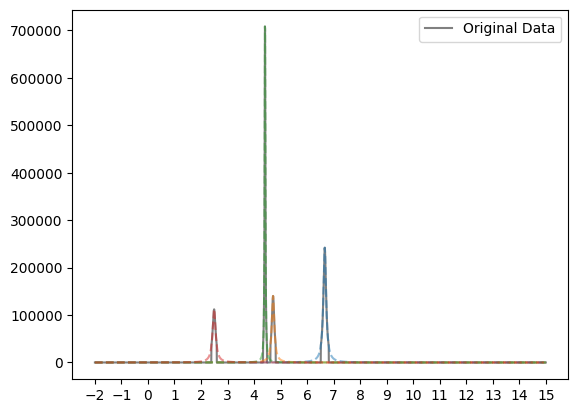

In [34]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")

target_train_tensor = target_train_tensor.to("cpu")
target_val_tensor = target_val_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")

data_train_tensor = data_train_tensor.squeeze(1)
data_val_tensor = data_val_tensor.squeeze(1)
# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_val = data_scaler.inverse_transform(data_val_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor)


print(f'data_train: {data_train.shape}')
print(f'data_val: {data_val.shape}')
print(f'target_train: {target_train.shape}')

print(f'len substrates_list: {len(substrates_list)}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, 3, axis=1)
x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val, 3, axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, 3, axis=1)




n = 30
x = x_data[n]
# plot the data
#plt.plot(x, data_train[n, :], '-', label='Original Data')
# for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)

# plt.plot(x, data_val[n, :], '-', label='Original Data', color='grey')
# for x0, gamma, height in zip(x0_parms_val[n], gamma_parms_val[n], height_parms_val[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)   
    
#fig = plt.figure(figsize=(10, 8))

plt.plot(x, data_test[n, :], '-', label='Original Data', color='grey')
for x0, gamma, height in zip(x0_parms_test[n], gamma_parms_test[n], height_parms_test[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', alpha=0.5)

plt.xticks(np.arange(-2, 16, 1))
plt.legend()
plt.show()

# Validate on real Data

In [35]:
# # Use a dataframe to collect general evaluation results
# results = pd.DataFrame()

# # We will reuse this function. Hence we copy it to mads_dl.py
# def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
#     '''
#     Create a table with evaluation results
#     of a regression experiment
#     '''
#     for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
#         mse=mean_squared_error(actual, predicted)
#         results= pd.concat([results, pd.DataFrame([{
#             "algorithm": algorithm, 
#             "dataset": dataset,
#             "MSE": mse,
#             "RMSE": math.sqrt(mse),
#             "MAE": mean_absolute_error(actual, predicted),
#             "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
#             "params": num_params
#         }])], ignore_index=True)   
#     return results


# Test on Data

(1, 3000)


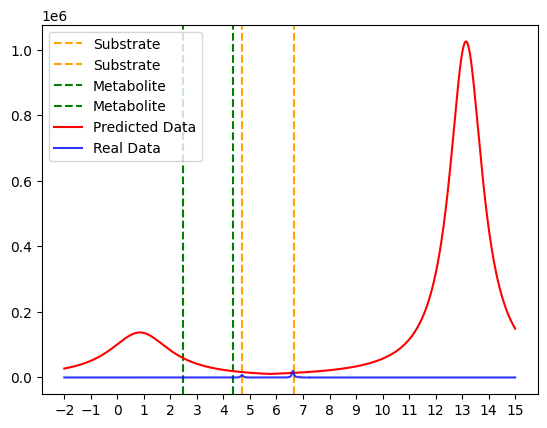

(1, 3000)


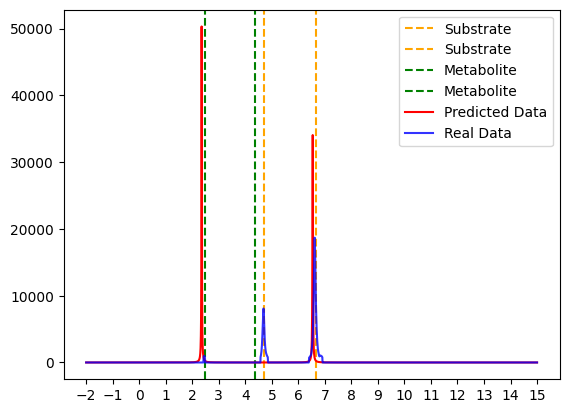

(1, 3000)


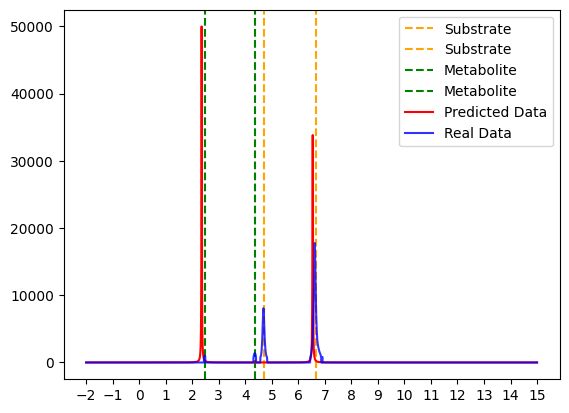

(1, 3000)


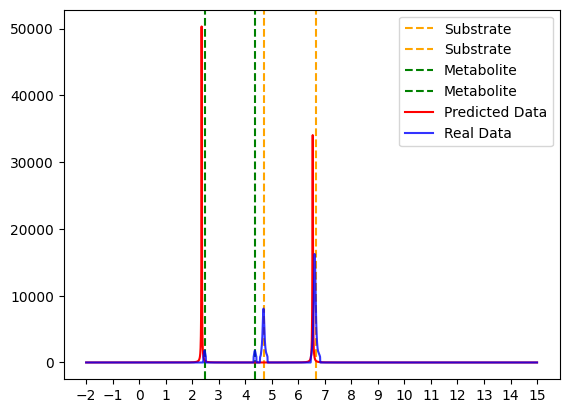

(1, 3000)


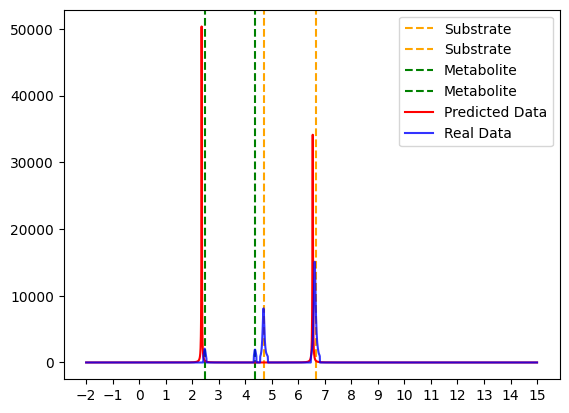

(1, 3000)


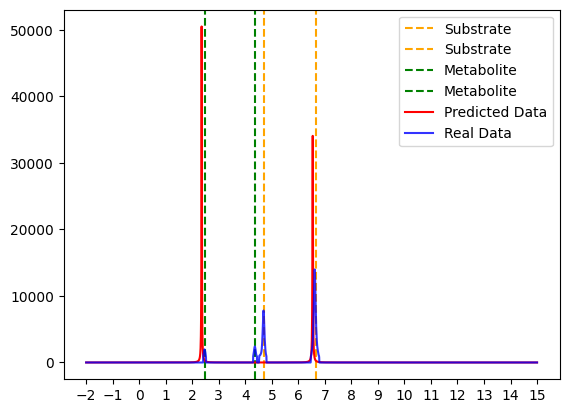

(1, 3000)


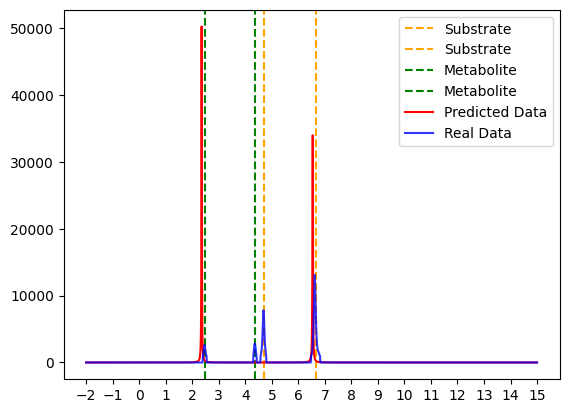

(1, 3000)


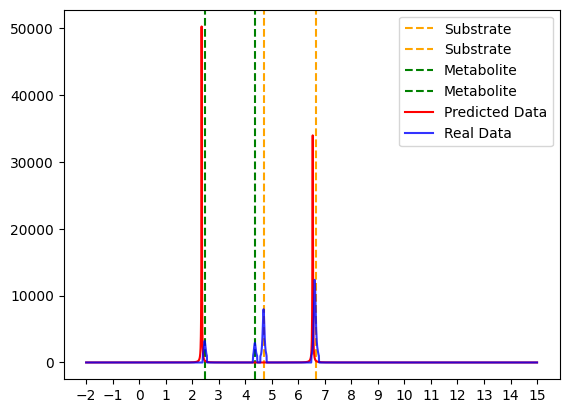

(1, 3000)


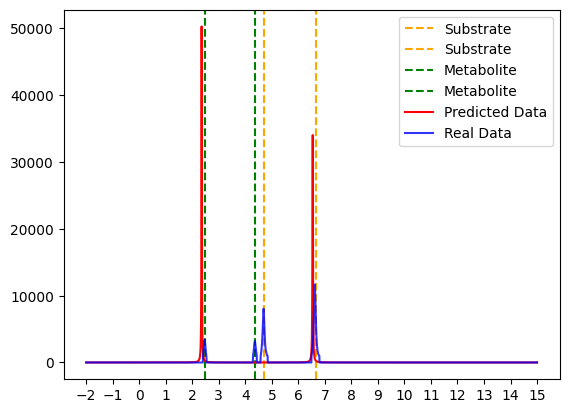

(1, 3000)


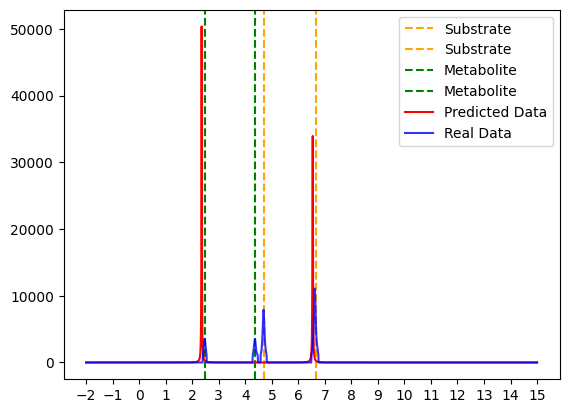

(1, 3000)


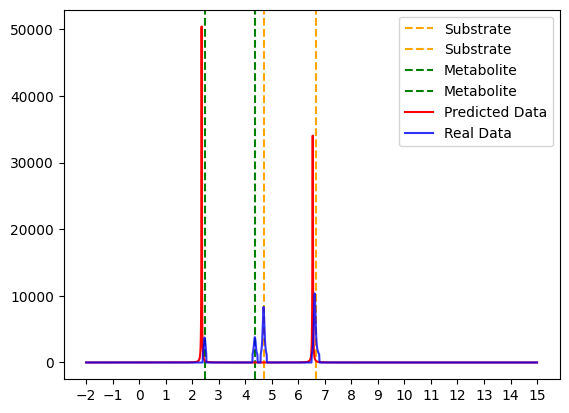

(1, 3000)


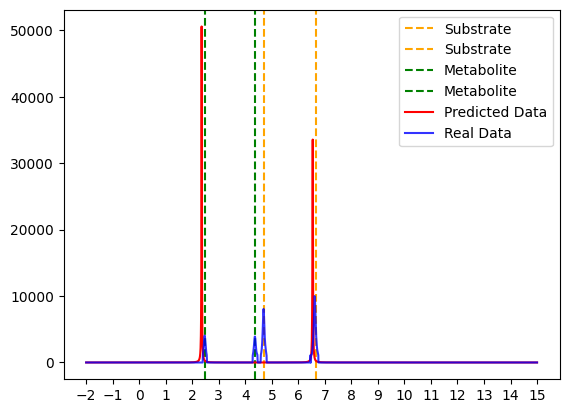

(1, 3000)


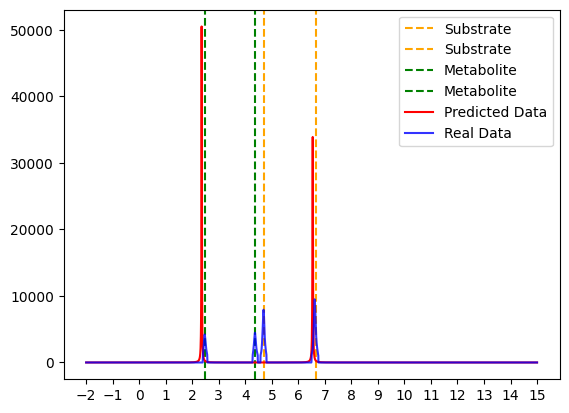

(1, 3000)


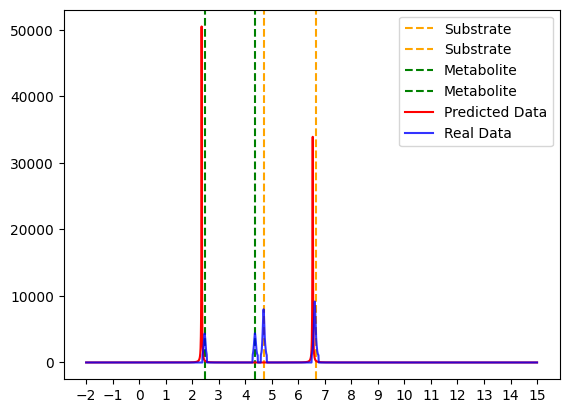

(1, 3000)


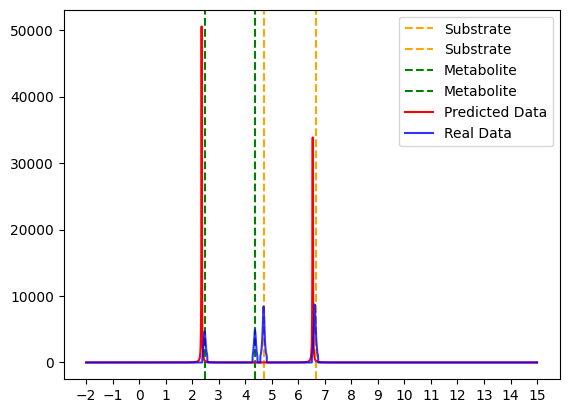

(1, 3000)


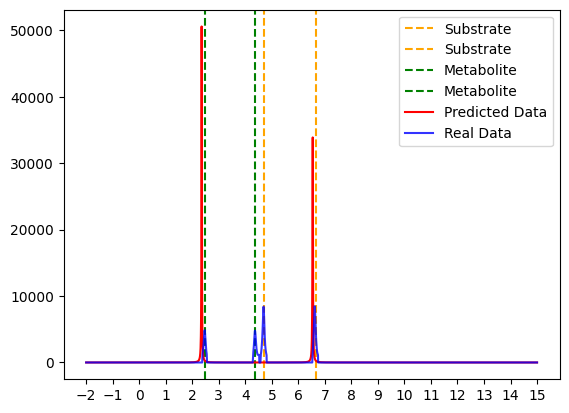

(1, 3000)


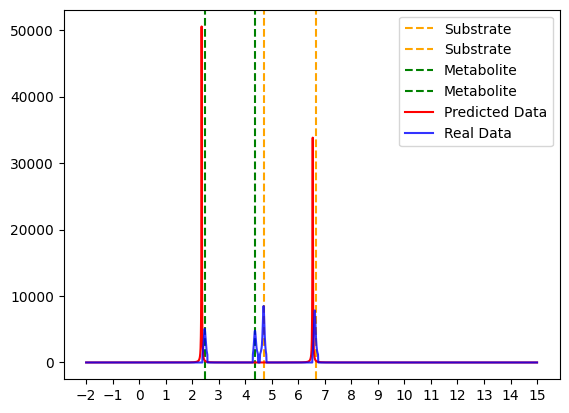

(1, 3000)


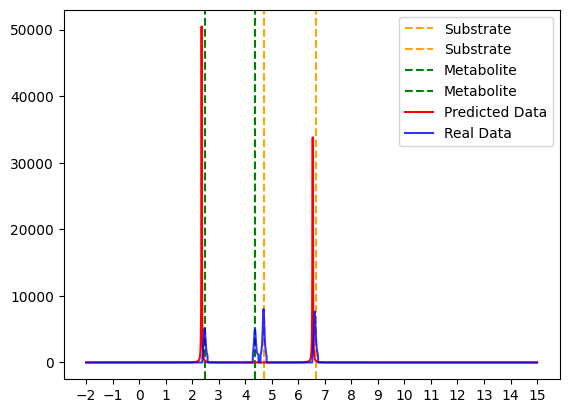

(1, 3000)


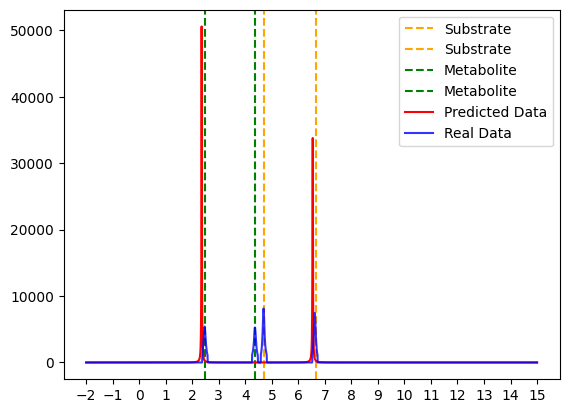

(1, 3000)


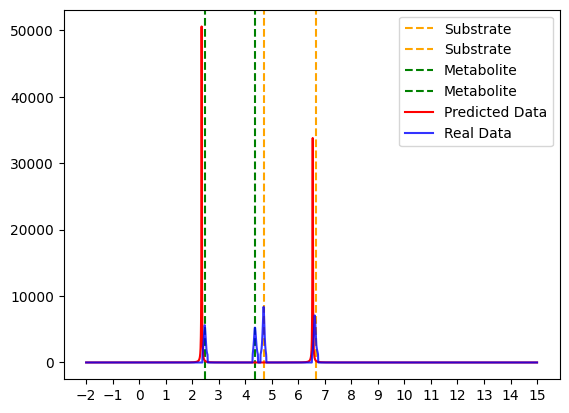

(1, 3000)


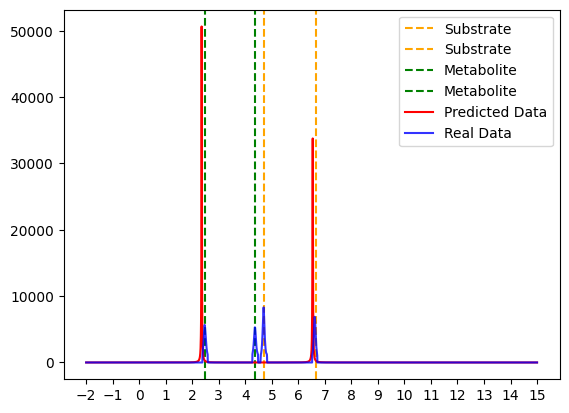

(1, 3000)


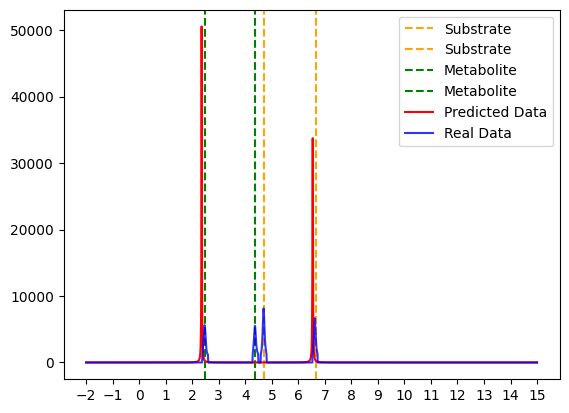

(1, 3000)


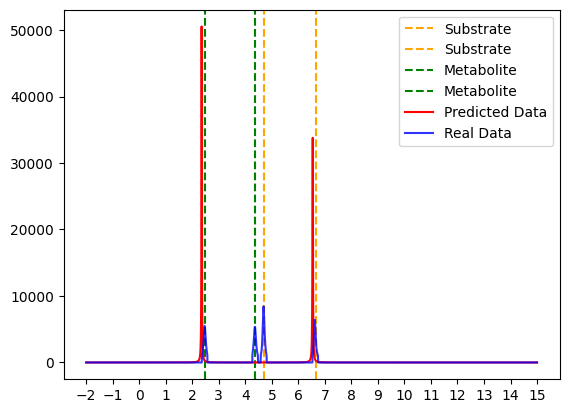

(1, 3000)


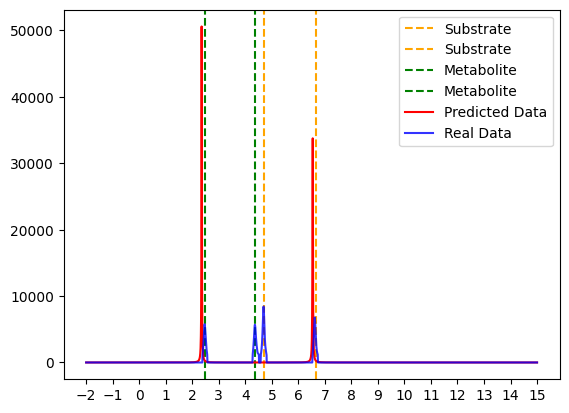

(1, 3000)


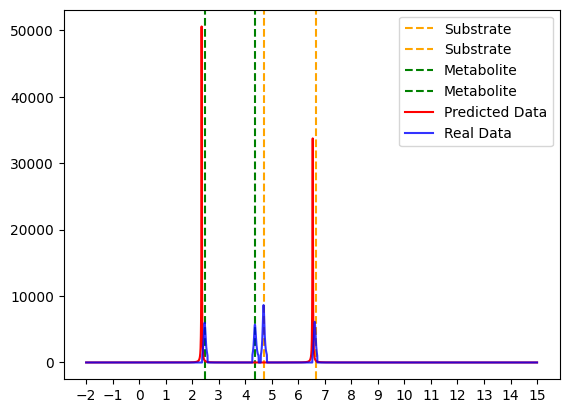

(1, 3000)


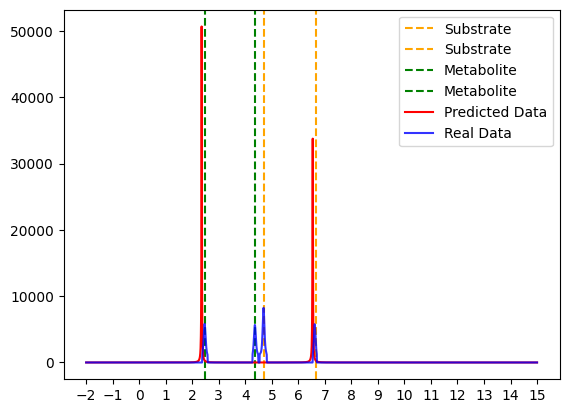

(1, 3000)


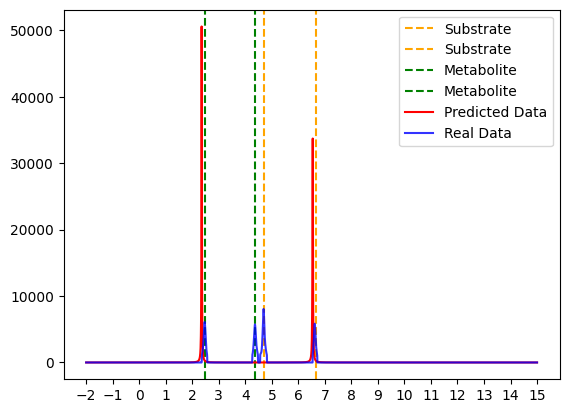

(1, 3000)


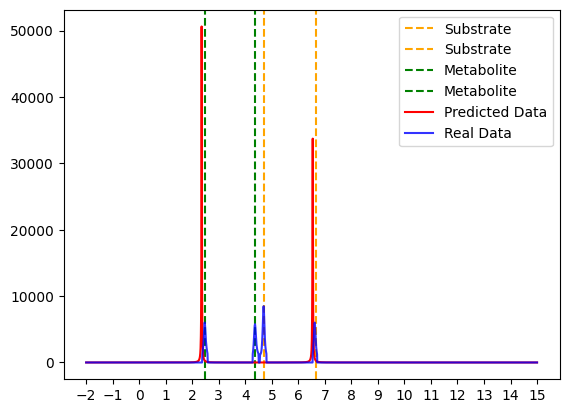

(1, 3000)


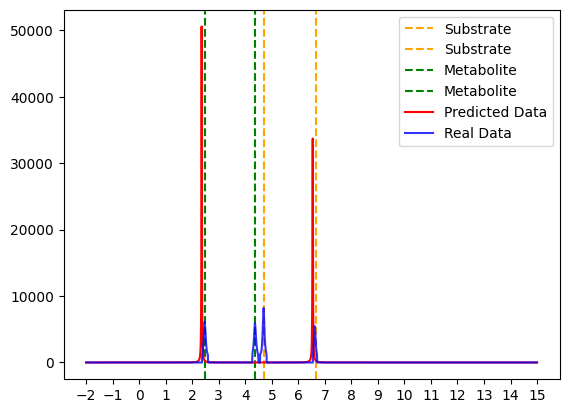

In [36]:
df = pd.read_csv(path_list[0]) 

for i in range(1, 30):
    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    print(y_real_sc.shape)

    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    # bring the data back to the cpu
    target_real_pred = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

    # calcualte the mse
    #mse = calculate_mse_of_real_data(df, model, random=False, i=i)
    #print(mse)
    
    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)
    


    for subs in substrates:
        plt.axvline(x=subs, color='orange', linestyle='--', label='Substrate')

    for metab in metabolites:
        plt.axvline(x=metab, color='green', linestyle='--', label='Metabolite')

    
    plt.plot(x_real, lorentz_df['max'], label='Predicted Data', color='red')
    plt.plot(x_real, y_real, label='Real Data', color='blue', alpha=0.8)

    plt.xticks(np.arange(-2, 16, 1))
    plt.legend()
    plt.show()

In [37]:
substrates, metabolites

([6.653, 4.7], [4.368, 2.474])